# Анализ лояльности пользователей Яндекс Афиши

## Этапы выполнения проекта

### 1. Загрузка данных и их предобработка

---

**Задача 1.1:** Напишите SQL-запрос, выгружающий в датафрейм pandas необходимые данные. Используйте следующие параметры для подключения к базе данных `data-analyst-afisha`:

- **Хост** — `rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net`
- **База данных** — `data-analyst-afisha`
- **Порт** — `6432`
- **Аутентификация** — `Database Native`
- **Пользователь** — `praktikum_student`
- **Пароль** — `Sdf4$2;d-d30pp`

Для выгрузки используйте запрос из предыдущего урока и библиотеку SQLAlchemy.

Выгрузка из базы данных SQL должна позволить собрать следующие данные:

- `user_id` — уникальный идентификатор пользователя, совершившего заказ;
- `device_type_canonical` — тип устройства, с которого был оформлен заказ (`mobile` — мобильные устройства, `desktop` — стационарные);
- `order_id` — уникальный идентификатор заказа;
- `order_dt` — дата создания заказа (используйте данные `created_dt_msk`);
- `order_ts` — дата и время создания заказа (используйте данные `created_ts_msk`);
- `currency_code` — валюта оплаты;
- `revenue` — выручка от заказа;
- `tickets_count` — количество купленных билетов;
- `days_since_prev` — количество дней от предыдущей покупки пользователя, для пользователей с одной покупкой — значение пропущено;
- `event_id` — уникальный идентификатор мероприятия;
- `service_name` — название билетного оператора;
- `event_type_main` — основной тип мероприятия (театральная постановка, концерт и так далее);
- `region_name` — название региона, в котором прошло мероприятие;
- `city_name` — название города, в котором прошло мероприятие.

---


In [249]:
import pandas as pd
from sqlalchemy import create_engine
from datetime import datetime
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
from phik import phik_matrix


In [250]:
db_config = {
    'user': 'praktikum_student', # имя пользователя
    'pwd': 'Sdf4$2;d-d30pp', # пароль
    'host': 'rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net',
    'port': 6432, # порт подключения
    'db': 'data-analyst-afisha' # название базы данных
}
connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db'],
)

In [251]:
# создание соединения 
engine = create_engine(connection_string)

In [252]:
# извлечение результатов sql запроса
query = '''
WITH purchases_enriched AS (
  SELECT
    p.user_id,
    p.device_type_canonical,
    p.order_id,
    p.created_dt_msk as order_dt,
    p.created_ts_msk as order_ts,
    p.currency_code,
    p.revenue,
    p.tickets_count,
    (
      created_dt_msk::date
      - LAG(created_dt_msk::date) OVER (
          PARTITION BY user_id
          ORDER BY created_dt_msk
        )
    )::int AS days_since_prev,
    p.event_id,
    e.event_name_code as event_name,
    e.event_type_main,
    p.service_name,
    r.region_name,
    c.city_name
  FROM afisha.purchases p
  INNER JOIN afisha.events e ON e.event_id = p.event_id
  LEFT JOIN afisha.city c ON c.city_id = e.city_id
  LEFT JOIN afisha.regions r ON r.region_id = c.region_id
  WHERE device_type_canonical IN ('mobile', 'desktop') AND e.event_type_main != 'фильм'
)
SELECT *
FROM purchases_enriched
ORDER BY user_id ASC;
'''

In [253]:
df = pd.read_sql_query(query, con=engine)

---

**Задача 1.2:** Изучите общую информацию о выгруженных данных. Оцените корректность выгрузки и объём полученных данных.

Предположите, какие шаги необходимо сделать на стадии предобработки данных — например, скорректировать типы данных.

Зафиксируйте основную информацию о данных в кратком промежуточном выводе.

---

In [254]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290611 entries, 0 to 290610
Data columns (total 15 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   user_id                290611 non-null  object        
 1   device_type_canonical  290611 non-null  object        
 2   order_id               290611 non-null  int64         
 3   order_dt               290611 non-null  datetime64[ns]
 4   order_ts               290611 non-null  datetime64[ns]
 5   currency_code          290611 non-null  object        
 6   revenue                290611 non-null  float64       
 7   tickets_count          290611 non-null  int64         
 8   days_since_prev        268678 non-null  float64       
 9   event_id               290611 non-null  int64         
 10  event_name             290611 non-null  object        
 11  event_type_main        290611 non-null  object        
 12  service_name           290611 non-null  obje

In [255]:
df.head()

,user_id,device_type_canonical,order_id,order_dt,order_ts,currency_code,revenue,tickets_count,days_since_prev,event_id,event_name,event_type_main,service_name,region_name,city_name
0,0002849b70a3ce2,mobile,4359165,2024-08-20,2024-08-20 16:08:03,rub,1521.94,4,NaN,169230,f0f7b271-04eb-4af6-bcb8-8f05cf46d6ad,театр,Край билетов,Каменевский регион,Глиногорск
1,0005ca5e93f2cf4,mobile,7965605,2024-07-23,2024-07-23 18:36:24,rub,289.45,2,NaN,237325,40efeb04-81b7-4135-b41f-708ff00cc64c,выставки,Мой билет,Каменевский регион,Глиногорск
2,0005ca5e93f2cf4,mobile,7292370,2024-10-06,2024-10-06 13:56:02,rub,1258.57,4,75.0,578454,01f3fb7b-ed07-4f94-b1d3-9a2e1ee5a8ca,другое,За билетом!,Каменевский регион,Глиногорск
3,000898990054619,mobile,1139875,2024-07-13,2024-07-13 19:40:48,rub,8.49,2,NaN,387271,2f638715-8844-466c-b43f-378a627c419f,другое,Лови билет!,Североярская область,Озёрск
4,000898990054619,mobile,972400,2024-10-04,2024-10-04 22:33:15,rub,1390.41,3,83.0,509453,10d805d3-9809-4d8a-834e-225b7d03f95d,стендап,Билеты без проблем,Озернинский край,Родниковецк


###  Промежуточный вывод:
- типы данных соответствуют описанию
- можно провести понижение размерностей для экономии памяти в колонках: order_id, revenue, tickets_count, days_since_prev, event_id

---

###  2. Предобработка данных

Выполните все стандартные действия по предобработке данных:

---

**Задача 2.1:** Данные о выручке сервиса представлены в российских рублях и казахстанских тенге. Приведите выручку к единой валюте — российскому рублю.

Для этого используйте датасет с информацией о курсе казахстанского тенге по отношению к российскому рублю за 2024 год — `final_tickets_tenge_df.csv`. Его можно загрузить по пути `https://code.s3.yandex.net/datasets/final_tickets_tenge_df.csv')`

Значения в рублях представлено для 100 тенге.

Результаты преобразования сохраните в новый столбец `revenue_rub`.

---


In [256]:
df_rub_tenge_exch = pd.read_csv('https://code.s3.yandex.net/datasets/final_tickets_tenge_df.csv')

In [257]:
df_rub_tenge_exch.head()

,data,nominal,curs,cdx
0,2024-01-10,100,19.9391,kzt
1,2024-01-11,100,19.7255,kzt
2,2024-01-12,100,19.5839,kzt
3,2024-01-13,100,19.4501,kzt
4,2024-01-14,100,19.4501,kzt


In [258]:
# подготовка данных в столбцах времени
df['order_dt'] = pd.to_datetime(df['order_dt']).dt.normalize()
df_rub_tenge_exch['data'] = pd.to_datetime(df_rub_tenge_exch['data']).dt.normalize()

In [259]:
# Подтягиваем курс тенге к рублю на дату заказа
df = df.merge(
    df_rub_tenge_exch[['data', 'curs']],
    left_on='order_dt',
    right_on='data',
    how='left'
)

In [260]:
df['revenue_rub'] = np.where(
    df['currency_code'].eq('kzt'),
    df['revenue'] * df['curs'] / 100,
    df['revenue']
)

In [261]:
# удаление технических колонок
df = df.drop(columns=['data', 'curs'])

In [262]:
df.head()

,user_id,device_type_canonical,order_id,order_dt,order_ts,currency_code,revenue,tickets_count,days_since_prev,event_id,event_name,event_type_main,service_name,region_name,city_name,revenue_rub
0,0002849b70a3ce2,mobile,4359165,2024-08-20,2024-08-20 16:08:03,rub,1521.94,4,NaN,169230,f0f7b271-04eb-4af6-bcb8-8f05cf46d6ad,театр,Край билетов,Каменевский регион,Глиногорск,1521.94
1,0005ca5e93f2cf4,mobile,7965605,2024-07-23,2024-07-23 18:36:24,rub,289.45,2,NaN,237325,40efeb04-81b7-4135-b41f-708ff00cc64c,выставки,Мой билет,Каменевский регион,Глиногорск,289.45
2,0005ca5e93f2cf4,mobile,7292370,2024-10-06,2024-10-06 13:56:02,rub,1258.57,4,75.0,578454,01f3fb7b-ed07-4f94-b1d3-9a2e1ee5a8ca,другое,За билетом!,Каменевский регион,Глиногорск,1258.57
3,000898990054619,mobile,1139875,2024-07-13,2024-07-13 19:40:48,rub,8.49,2,NaN,387271,2f638715-8844-466c-b43f-378a627c419f,другое,Лови билет!,Североярская область,Озёрск,8.49
4,000898990054619,mobile,972400,2024-10-04,2024-10-04 22:33:15,rub,1390.41,3,83.0,509453,10d805d3-9809-4d8a-834e-225b7d03f95d,стендап,Билеты без проблем,Озернинский край,Родниковецк,1390.41


---

**Задача 2.2:**

- Проверьте данные на пропущенные значения. Если выгрузка из SQL была успешной, то пропуски должны быть только в столбце `days_since_prev`.
- Преобразуйте типы данных в некоторых столбцах, если это необходимо. Обратите внимание на данные с датой и временем, а также на числовые данные, размерность которых можно сократить.
- Изучите значения в ключевых столбцах. Обработайте ошибки, если обнаружите их.
    - Проверьте, какие категории указаны в столбцах с номинальными данными. Есть ли среди категорий такие, что обозначают пропуски в данных или отсутствие информации? Проведите нормализацию данных, если это необходимо.
    - Проверьте распределение численных данных и наличие в них выбросов. Для этого используйте статистические показатели, гистограммы распределения значений или диаграммы размаха.
        
        Важные показатели в рамках поставленной задачи — это выручка с заказа (`revenue_rub`) и количество билетов в заказе (`tickets_count`), поэтому в первую очередь проверьте данные в этих столбцах.
        
        Если обнаружите выбросы в поле `revenue_rub`, то отфильтруйте значения по 99 перцентилю.

После предобработки проверьте, были ли отфильтрованы данные. Если были, то оцените, в каком объёме. Сформулируйте промежуточный вывод, зафиксировав основные действия и описания новых столбцов.

---

In [263]:
# 1) Проверка на пропуски
df.isna().sum() / len(df) * 100

user_id                  0.000000
device_type_canonical    0.000000
order_id                 0.000000
order_dt                 0.000000
order_ts                 0.000000
currency_code            0.000000
revenue                  0.000000
tickets_count            0.000000
days_since_prev          7.547202
event_id                 0.000000
event_name               0.000000
event_type_main          0.000000
service_name             0.000000
region_name              0.000000
city_name                0.000000
revenue_rub              0.000000
dtype: float64

### Анализ
- в столбце days_since_prev 7.5% пропусков. Доля пропусков существенная, удалять не будем. Оставляем как есть
- в двугих столбцах пропусков нет

Следловательно, выгрузка из SQL прошла успешно

In [264]:
# 2) Преобразование типов данных в колонках
'''
- Преобразуйте типы данных в некоторых столбцах, если это необходимо. Обратите внимание на данные с датой и временем, а также на числовые данные, размерность которых можно сократить.
'''
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290611 entries, 0 to 290610
Data columns (total 16 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   user_id                290611 non-null  object        
 1   device_type_canonical  290611 non-null  object        
 2   order_id               290611 non-null  int64         
 3   order_dt               290611 non-null  datetime64[ns]
 4   order_ts               290611 non-null  datetime64[ns]
 5   currency_code          290611 non-null  object        
 6   revenue                290611 non-null  float64       
 7   tickets_count          290611 non-null  int64         
 8   days_since_prev        268678 non-null  float64       
 9   event_id               290611 non-null  int64         
 10  event_name             290611 non-null  object        
 11  event_type_main        290611 non-null  object        
 12  service_name           290611 non-null  obje

In [265]:
# преобразования типов, понижение размерностей
def downcast_type(col_name: str, type_name: str):
    return pd.to_numeric(df[col_name], downcast=type_name)

In [266]:
col_to_int_downcast = ['order_id', 'tickets_count', 'event_id']

for col in col_to_int_downcast:
    df[col] = downcast_type(col, 'integer')

In [267]:
col_to_float_downcast = ['days_since_prev', 'revenue', 'revenue_rub']

for col in col_to_float_downcast:
    df[col] = downcast_type(col, 'float')

In [268]:
# преобразование дат для уменьшения избыточности
df['order_dt'] = df['order_dt'].dt.floor('D')   # оставляем только дату

In [269]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290611 entries, 0 to 290610
Data columns (total 16 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   user_id                290611 non-null  object        
 1   device_type_canonical  290611 non-null  object        
 2   order_id               290611 non-null  int32         
 3   order_dt               290611 non-null  datetime64[ns]
 4   order_ts               290611 non-null  datetime64[ns]
 5   currency_code          290611 non-null  object        
 6   revenue                290611 non-null  float64       
 7   tickets_count          290611 non-null  int8          
 8   days_since_prev        268678 non-null  float32       
 9   event_id               290611 non-null  int32         
 10  event_name             290611 non-null  object        
 11  event_type_main        290611 non-null  object        
 12  service_name           290611 non-null  obje

- Изучите значения в ключевых столбцах. Обработайте ошибки, если обнаружите их.
    - Проверьте, какие категории указаны в столбцах с номинальными данными. Есть ли среди категорий такие, что обозначают пропуски в данных или отсутствие информации? Проведите нормализацию данных, если это необходимо.
    - Проверьте распределение численных данных и наличие в них выбросов. Для этого используйте статистические показатели, гистограммы распределения значений или диаграммы размаха.
        
        Важные показатели в рамках поставленной задачи — это выручка с заказа (`revenue_rub`) и количество билетов в заказе (`tickets_count`), поэтому в первую очередь проверьте данные в этих столбцах.
        
        Если обнаружите выбросы в поле `revenue_rub`, то отфильтруйте значения по 99 перцентилю.

После предобработки проверьте, были ли отфильтрованы данные. Если были, то оцените, в каком объёме. Сформулируйте промежуточный вывод, зафиксировав основные действия и описания новых столбцов.

### Изучение данных в ключевых столбцах

In [270]:
min(df['revenue'])

-90.76

- есть отрицательное значение прибыли revenue, это явно ошибка в данных

In [271]:
(df['revenue'] < 0).sum() / len(df) * 100

np.float64(0.13110308969722412)

- ошибочных данных по прибыли менее 0.2% Можно безболезненно удалить

In [272]:
df = df.drop(df[df['revenue'] < 0].index)

In [273]:
print((df['revenue'] < 0).sum() / len(df) * 100)
print((df['revenue_rub'] < 0).sum() / len(df) * 100) 

0.0
0.0


- ошибок теперь нет в revenue и revenue_rub

In [274]:
df['event_type_main'].unique()

array(['театр', 'выставки', 'другое', 'стендап', 'концерты', 'спорт',
       'ёлки'], dtype=object)

- 'другое' - флаг отсутствия информации 

In [275]:
(df['event_type_main'] == 'другое').sum() / len(df) * 100

np.float64(22.586224718326843)

- доля отсутствующей информации в event_type_main : 22.6%

In [276]:
def to_snake_case(value):
    """Преобразует одно значение в snake_case."""
    if pd.isna(value):
        return value
    s = str(value).strip().lower()
    s = re.sub(r"[^\w\s-]", "", s, flags=re.UNICODE)  
    s = re.sub(r"[\s\-]+", "_", s)                  
    s = re.sub(r"_+", "_", s).strip("_") 
    return s

def normalize_columns_snake_case(df, columns):
    """Нормализует указанные столбцы DataFrame в snake_case."""
    df = df.copy()
    for col in columns:
        df[col] = df[col].apply(to_snake_case)
    return df

In [277]:
# для строковых данных уместно провести нормализацию к snake_case
df = normalize_columns_snake_case(df, ['region_name', 'city_name', 'service_name'])

### Проверка распределения численных данных и наличия в них выбросов

- Проверьте распределение численных данных и наличие в них выбросов. Для этого используйте статистические показатели, гистограммы распределения значений или диаграммы размаха.
    
    Важные показатели в рамках поставленной задачи — это выручка с заказа (`revenue_rub`) и количество билетов в заказе (`tickets_count`), поэтому в первую очередь проверьте данные в этих столбцах.
    
    Если обнаружите выбросы в поле `revenue_rub`, то отфильтруйте значения по 99 перцентилю.

In [278]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 290230 entries, 0 to 290610
Data columns (total 16 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   user_id                290230 non-null  object        
 1   device_type_canonical  290230 non-null  object        
 2   order_id               290230 non-null  int32         
 3   order_dt               290230 non-null  datetime64[ns]
 4   order_ts               290230 non-null  datetime64[ns]
 5   currency_code          290230 non-null  object        
 6   revenue                290230 non-null  float64       
 7   tickets_count          290230 non-null  int8          
 8   days_since_prev        268329 non-null  float32       
 9   event_id               290230 non-null  int32         
 10  event_name             290230 non-null  object        
 11  event_type_main        290230 non-null  object        
 12  service_name           290230 non-null  object   

In [279]:
def discribe_analysis(column_to_analyse: pd.Series, qnt: float):
    extra_revenue_rub_bound = column_to_analyse.quantile(qnt)
    print(f'{qnt * 100} % значений менее {extra_revenue_rub_bound}')
    print('Минимальное значение: ', column_to_analyse.min())
    print('Медиана: ', column_to_analyse.median())
    print('Максимальное значение: ', column_to_analyse.max())
    print('Размах: ', column_to_analyse.max() - column_to_analyse.min())

In [280]:
# проверка распределения в данных
df[['revenue_rub', 'tickets_count', 'days_since_prev']].describe()


,revenue_rub,tickets_count,days_since_prev
count,290230.000000,290230.000000,268329.000000
mean,556.304587,2.755149,3.224120
std,875.838948,1.170634,11.354673
min,0.000000,1.000000,0.000000
25%,114.610000,2.000000,0.000000
50%,352.080000,3.000000,0.000000
75%,802.250000,4.000000,1.000000
max,81174.540000,57.000000,148.000000


99.0 % значений менее 2628.4217390400004
Минимальное значение:  0.0
Медиана:  352.08
Максимальное значение:  81174.54
Размах:  81174.54


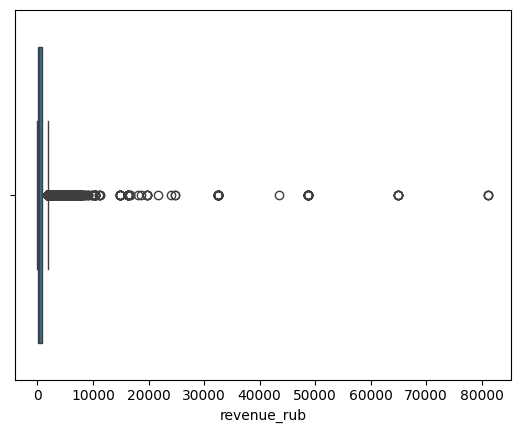

In [281]:
sns.boxplot(data=df, x='revenue_rub')
discribe_analysis(df['revenue_rub'], qnt=0.99)

- выбросы в revenue_rub есть: 99.0 % значений менее 2628 при максимальном значении 81175. Медианное значение 352.08

99.0 % значений менее 6.0
Минимальное значение:  1
Медиана:  3.0
Максимальное значение:  57
Размах:  56


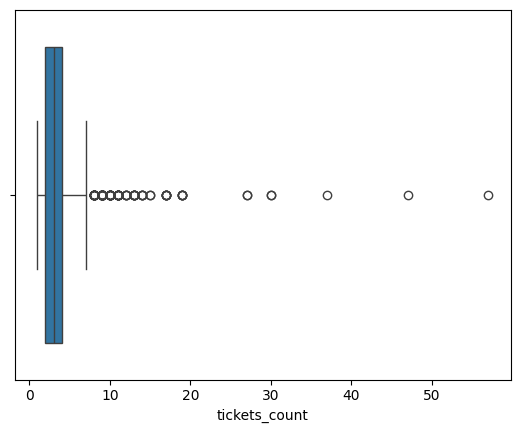

In [282]:
sns.boxplot(data=df, x='tickets_count')
discribe_analysis(df['tickets_count'], qnt=0.99)

- в столбце tickets_count есть выбросы: 99.0 % значений менее 6.0 при максимальном значении 57. Медиана:  3.0

99.0 % значений менее 63.0
Минимальное значение:  0.0
Медиана:  0.0
Максимальное значение:  148.0
Размах:  148.0


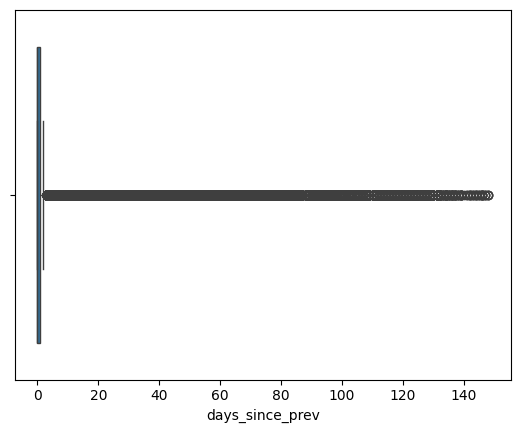

In [283]:
sns.boxplot(data=df, x='days_since_prev')
discribe_analysis(df['days_since_prev'], qnt=0.99)

- в столбце days_since_prev есть выбросы: 99.0 % значений менее 63.0 при максимальном значении 148. Медиана:  0.0

In [284]:
# Проведем фильтрацию значений для revenue_rub по 99 перцентилю
tmp = df.copy()

df = df.drop(df[df['revenue_rub'] > df['revenue_rub'].quantile(0.99)].index)

In [285]:
print('Потери при фильтрации по revenue_rub по 99 перцентилю: ', (len(tmp) - len(df)) / len(tmp) * 100, '%') 

Потери при фильтрации по revenue_rub по 99 перцентилю:  0.9733659511421976 %


### Промежуточный итог:

Наличие пропусков:
- пропуски есть только в столбце days_since_prev. Их доля 7.5%. Принято решение их оствить как есть.

Ошибки в данных:
- в столбцах 'revenue_rub', 'revenue' выявлены отрицательные значения. Это ошибки. Их доля менее 0.2%. Строки с ошибками удалены.

Отсутствующая информация:
- доля отсутствующей информации в event_type_main : 22.6%

Преобразование типов:
- для числовых данных проведено понижение размерностей в колонках: 'order_id', 'tickets_count', 'event_id', 'days_since_prev', 'revenue', 'revenue_rub'.
- уменьшена избыточность в колонке со временем order_dt

Нормализация данных:
- проведена для тестовых данных в 'region_name', 'city_name', 'service_name'

Новые столбцы:
- добавлен столбец revenue_rub с прибылью в рублях

Проверка распределения численных данных и наличия в них выбросов:
- выбросы в revenue_rub есть: 99.0 % значений менее 2628 при максимальном значении 81175. Медиана: 352.08
- в столбце tickets_count есть выбросы: 99.0 % значений менее 6.0 при максимальном значении 57. Медиана:  3.0
- в столбце days_since_prev есть выбросы: 99.0 % значений менее 63.0 при максимальном значении 148. Медиана:  0.0

Фильтрация важных для анализа данных:
- проведена фильтрация по 99 перцентилю для revenue_rub. Потери для датасета составили: 0.97%

---

### 3. Создание профиля пользователя

В будущем отдел маркетинга планирует создать модель для прогнозирования возврата пользователей. Поэтому сейчас они просят вас построить агрегированные признаки, описывающие поведение и профиль каждого пользователя.

---

**Задача 3.1.** Постройте профиль пользователя — для каждого пользователя найдите:

- дату первого и последнего заказа;
- устройство, с которого был сделан первый заказ;
- регион, в котором был сделан первый заказ;
- билетного партнёра, к которому обращались при первом заказе;
- жанр первого посещённого мероприятия (используйте поле `event_type_main`);
- общее количество заказов;
- средняя выручка с одного заказа в рублях;
- среднее количество билетов в заказе;
- среднее время между заказами.

После этого добавьте два бинарных признака:

- `is_two` — совершил ли пользователь 2 и более заказа;
- `is_five` — совершил ли пользователь 5 и более заказов.

**Рекомендация:** перед тем как строить профиль, отсортируйте данные по времени совершения заказа.

---


In [286]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 287405 entries, 0 to 290610
Data columns (total 16 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   user_id                287405 non-null  object        
 1   device_type_canonical  287405 non-null  object        
 2   order_id               287405 non-null  int32         
 3   order_dt               287405 non-null  datetime64[ns]
 4   order_ts               287405 non-null  datetime64[ns]
 5   currency_code          287405 non-null  object        
 6   revenue                287405 non-null  float64       
 7   tickets_count          287405 non-null  int8          
 8   days_since_prev        265711 non-null  float32       
 9   event_id               287405 non-null  int32         
 10  event_name             287405 non-null  object        
 11  event_type_main        287405 non-null  object        
 12  service_name           287405 non-null  object   

In [287]:
# построение профиля пользователя

In [288]:
df_ord_time_sorted = df.sort_values(by=['order_ts'], ascending=True) # предварительная сортировка по времени
df_ord_time_sorted.head()

,user_id,device_type_canonical,order_id,order_dt,order_ts,currency_code,revenue,tickets_count,days_since_prev,event_id,event_name,event_type_main,service_name,region_name,city_name,revenue_rub
285283,fd4d47438ebb946,mobile,7565637,2024-06-01,2024-06-01 00:00:42,rub,1083.15,4,0.0,131671,f4431442-3d97-452d-a6d6-eadf6bd34378,театр,прачечная,каменевский_регион,глиногорск,1083.15
285280,fd4d47438ebb946,mobile,7565521,2024-06-01,2024-06-01 00:01:30,rub,812.36,3,0.0,131671,f4431442-3d97-452d-a6d6-eadf6bd34378,театр,прачечная,каменевский_регион,глиногорск,812.36
118843,57ef0a1905ac488,mobile,6670842,2024-06-01,2024-06-01 00:01:58,rub,2091.31,4,NaN,375861,ba89f19f-e73c-4d74-ab35-b9c023bb4de6,театр,билеты_в_руки,лесодальний_край,родниковец,2091.31
285281,fd4d47438ebb946,mobile,7565550,2024-06-01,2024-06-01 00:03:13,rub,812.36,3,0.0,131671,f4431442-3d97-452d-a6d6-eadf6bd34378,театр,прачечная,каменевский_регион,глиногорск,812.36
264550,e73089d7d016cd8,mobile,5502055,2024-06-01,2024-06-01 00:03:34,rub,181.39,2,0.0,211846,20165b73-7202-48df-a5e3-fd8cd1a70554,театр,прачечная,широковская_область,радужнополье,181.39


In [289]:
# данные о первых заказах клиентов
first_ord_info = df_ord_time_sorted.groupby('user_id').first().reset_index()
first_ord_info = first_ord_info[['user_id', 'device_type_canonical', 'order_id', 'order_ts', 'region_name', 'service_name', 'event_type_main']]
first_ord_info = first_ord_info.rename(columns={
    'device_type_canonical': 'first_order_device', 'order_id': 'first_order_id', 
    'order_ts': 'first_order_ts', 'region_name': 'first_order_region_name', 'service_name': 'first_order_service_name', 'event_type_main': 'first_order_event_type_main'
    })
first_ord_info.head()

,user_id,first_order_device,first_order_id,first_order_ts,first_order_region_name,first_order_service_name,first_order_event_type_main
0,0002849b70a3ce2,mobile,4359165,2024-08-20 16:08:03,каменевский_регион,край_билетов,театр
1,0005ca5e93f2cf4,mobile,7965605,2024-07-23 18:36:24,каменевский_регион,мой_билет,выставки
2,000898990054619,mobile,1139875,2024-07-13 19:40:48,североярская_область,лови_билет,другое
3,00096d1f542ab2b,desktop,6636941,2024-08-15 16:48:48,каменевский_регион,край_билетов,театр
4,000a55a418c128c,mobile,4657981,2024-09-29 19:39:12,поленовский_край,лучшие_билеты,театр


In [290]:
# время последнего заказа
last_ord_time = df_ord_time_sorted.groupby('user_id')['order_ts'].max().reset_index()
last_ord_time.head()

,user_id,order_ts
0,0002849b70a3ce2,2024-08-20 16:08:03
1,0005ca5e93f2cf4,2024-10-06 13:56:02
2,000898990054619,2024-10-23 15:12:00
3,00096d1f542ab2b,2024-08-15 16:48:48
4,000a55a418c128c,2024-10-15 10:29:04


In [291]:
df_users_profile = pd.merge(first_ord_info, last_ord_time, on='user_id', suffixes=("_first", "_last"))
df_users_profile.head()


,user_id,first_order_device,first_order_id,first_order_ts,first_order_region_name,first_order_service_name,first_order_event_type_main,order_ts
0,0002849b70a3ce2,mobile,4359165,2024-08-20 16:08:03,каменевский_регион,край_билетов,театр,2024-08-20 16:08:03
1,0005ca5e93f2cf4,mobile,7965605,2024-07-23 18:36:24,каменевский_регион,мой_билет,выставки,2024-10-06 13:56:02
2,000898990054619,mobile,1139875,2024-07-13 19:40:48,североярская_область,лови_билет,другое,2024-10-23 15:12:00
3,00096d1f542ab2b,desktop,6636941,2024-08-15 16:48:48,каменевский_регион,край_билетов,театр,2024-08-15 16:48:48
4,000a55a418c128c,mobile,4657981,2024-09-29 19:39:12,поленовский_край,лучшие_билеты,театр,2024-10-15 10:29:04


In [292]:
# общее кол-во заказов
tot_order_count = df_ord_time_sorted.groupby('user_id')['order_id'].count().reset_index()
tot_order_count = tot_order_count.rename(columns={'order_id': 'total_order_count'})
df_users_profile = pd.merge(df_users_profile, tot_order_count, on='user_id')
df_users_profile.head()


,user_id,first_order_device,first_order_id,first_order_ts,first_order_region_name,first_order_service_name,first_order_event_type_main,order_ts,total_order_count
0,0002849b70a3ce2,mobile,4359165,2024-08-20 16:08:03,каменевский_регион,край_билетов,театр,2024-08-20 16:08:03,1
1,0005ca5e93f2cf4,mobile,7965605,2024-07-23 18:36:24,каменевский_регион,мой_билет,выставки,2024-10-06 13:56:02,2
2,000898990054619,mobile,1139875,2024-07-13 19:40:48,североярская_область,лови_билет,другое,2024-10-23 15:12:00,3
3,00096d1f542ab2b,desktop,6636941,2024-08-15 16:48:48,каменевский_регион,край_билетов,театр,2024-08-15 16:48:48,1
4,000a55a418c128c,mobile,4657981,2024-09-29 19:39:12,поленовский_край,лучшие_билеты,театр,2024-10-15 10:29:04,2


In [293]:
# средняя выручка с одного заказа
avg_order_revenue = df_ord_time_sorted.groupby('user_id')['revenue_rub'].mean().reset_index()
avg_order_revenue = avg_order_revenue.rename(columns={'revenue_rub': 'avg_order_revenue'})
df_users_profile = pd.merge(df_users_profile, avg_order_revenue, on='user_id')
df_users_profile.head()

,user_id,first_order_device,first_order_id,first_order_ts,first_order_region_name,first_order_service_name,first_order_event_type_main,order_ts,total_order_count,avg_order_revenue
0,0002849b70a3ce2,mobile,4359165,2024-08-20 16:08:03,каменевский_регион,край_билетов,театр,2024-08-20 16:08:03,1,1521.940000
1,0005ca5e93f2cf4,mobile,7965605,2024-07-23 18:36:24,каменевский_регион,мой_билет,выставки,2024-10-06 13:56:02,2,774.010000
2,000898990054619,mobile,1139875,2024-07-13 19:40:48,североярская_область,лови_билет,другое,2024-10-23 15:12:00,3,767.213333
3,00096d1f542ab2b,desktop,6636941,2024-08-15 16:48:48,каменевский_регион,край_билетов,театр,2024-08-15 16:48:48,1,917.830000
4,000a55a418c128c,mobile,4657981,2024-09-29 19:39:12,поленовский_край,лучшие_билеты,театр,2024-10-15 10:29:04,2,61.310000


In [294]:
# среднее количество билетов
avg_order_tickets = df_ord_time_sorted.groupby('user_id')['tickets_count'].mean().reset_index()
avg_order_tickets = avg_order_tickets.rename(columns={'tickets_count': 'avg_order_tickets'})
df_users_profile = pd.merge(df_users_profile, avg_order_tickets, on='user_id')
df_users_profile.head()

,user_id,first_order_device,first_order_id,first_order_ts,first_order_region_name,first_order_service_name,first_order_event_type_main,order_ts,total_order_count,avg_order_revenue,avg_order_tickets
0,0002849b70a3ce2,mobile,4359165,2024-08-20 16:08:03,каменевский_регион,край_билетов,театр,2024-08-20 16:08:03,1,1521.940000,4.000000
1,0005ca5e93f2cf4,mobile,7965605,2024-07-23 18:36:24,каменевский_регион,мой_билет,выставки,2024-10-06 13:56:02,2,774.010000,3.000000
2,000898990054619,mobile,1139875,2024-07-13 19:40:48,североярская_область,лови_билет,другое,2024-10-23 15:12:00,3,767.213333,2.666667
3,00096d1f542ab2b,desktop,6636941,2024-08-15 16:48:48,каменевский_регион,край_билетов,театр,2024-08-15 16:48:48,1,917.830000,4.000000
4,000a55a418c128c,mobile,4657981,2024-09-29 19:39:12,поленовский_край,лучшие_билеты,театр,2024-10-15 10:29:04,2,61.310000,1.500000


In [295]:
# среднее время между заказами
avg_time_between_orders = df_ord_time_sorted.groupby('user_id')['order_ts'].apply(lambda x: x.diff().mean()).reset_index()
avg_time_between_orders = avg_time_between_orders.rename(columns={'order_ts': 'avg_time_between_orders'})
df_users_profile = pd.merge(df_users_profile, avg_time_between_orders, on='user_id')
df_users_profile.head()

,user_id,first_order_device,first_order_id,first_order_ts,first_order_region_name,first_order_service_name,first_order_event_type_main,order_ts,total_order_count,avg_order_revenue,avg_order_tickets,avg_time_between_orders
0,0002849b70a3ce2,mobile,4359165,2024-08-20 16:08:03,каменевский_регион,край_билетов,театр,2024-08-20 16:08:03,1,1521.940000,4.000000,NaT
1,0005ca5e93f2cf4,mobile,7965605,2024-07-23 18:36:24,каменевский_регион,мой_билет,выставки,2024-10-06 13:56:02,2,774.010000,3.000000,74 days 19:19:38
2,000898990054619,mobile,1139875,2024-07-13 19:40:48,североярская_область,лови_билет,другое,2024-10-23 15:12:00,3,767.213333,2.666667,50 days 21:45:36
3,00096d1f542ab2b,desktop,6636941,2024-08-15 16:48:48,каменевский_регион,край_билетов,театр,2024-08-15 16:48:48,1,917.830000,4.000000,NaT
4,000a55a418c128c,mobile,4657981,2024-09-29 19:39:12,поленовский_край,лучшие_билеты,театр,2024-10-15 10:29:04,2,61.310000,1.500000,15 days 14:49:52


In [296]:
# совершил ли пользователь более 2х, 5ти заказов
df_users_profile['is_two'] = (df_users_profile['total_order_count'] >= 2)
df_users_profile['is_five'] = (df_users_profile['total_order_count'] >= 5)
df_users_profile.head()

,user_id,first_order_device,first_order_id,first_order_ts,first_order_region_name,first_order_service_name,first_order_event_type_main,order_ts,total_order_count,avg_order_revenue,avg_order_tickets,avg_time_between_orders,is_two,is_five
0,0002849b70a3ce2,mobile,4359165,2024-08-20 16:08:03,каменевский_регион,край_билетов,театр,2024-08-20 16:08:03,1,1521.940000,4.000000,NaT,False,False
1,0005ca5e93f2cf4,mobile,7965605,2024-07-23 18:36:24,каменевский_регион,мой_билет,выставки,2024-10-06 13:56:02,2,774.010000,3.000000,74 days 19:19:38,True,False
2,000898990054619,mobile,1139875,2024-07-13 19:40:48,североярская_область,лови_билет,другое,2024-10-23 15:12:00,3,767.213333,2.666667,50 days 21:45:36,True,False
3,00096d1f542ab2b,desktop,6636941,2024-08-15 16:48:48,каменевский_регион,край_билетов,театр,2024-08-15 16:48:48,1,917.830000,4.000000,NaT,False,False
4,000a55a418c128c,mobile,4657981,2024-09-29 19:39:12,поленовский_край,лучшие_билеты,театр,2024-10-15 10:29:04,2,61.310000,1.500000,15 days 14:49:52,True,False


---

**Задача 3.2.** Прежде чем проводить исследовательский анализ данных и делать выводы, важно понять, с какими данными вы работаете: насколько они репрезентативны и нет ли в них аномалий.

Используя данные о профилях пользователей, рассчитайте:

- общее число пользователей в выборке;
- среднюю выручку с одного заказа;
- долю пользователей, совершивших 2 и более заказа;
- долю пользователей, совершивших 5 и более заказов.

Также изучите статистические показатели:

- по общему числу заказов;
- по среднему числу билетов в заказе;
- по среднему количеству дней между покупками.

По результатам оцените данные: достаточно ли их по объёму, есть ли аномальные значения в данных о количестве заказов и среднем количестве билетов?

Если вы найдёте аномальные значения, опишите их и примите обоснованное решение о том, как с ними поступить:

- Оставить и учитывать их при анализе?
- Отфильтровать данные по какому-то значению, например, по 95-му или 99-му перцентилю?

Если вы проведёте фильтрацию, то вычислите объём отфильтрованных данных и выведите статистические показатели по обновлённому датасету.

In [297]:
tot_users_count = len(df_users_profile)
print('общее число пользователей: ', tot_users_count)

общее число пользователей:  21838


In [298]:
avg_ord_rev = df_users_profile['avg_order_revenue'].mean()
print('Средняя выручка с одного заказа: ', avg_ord_rev)

Средняя выручка с одного заказа:  545.0328001021667


In [299]:
is_two_part = df_users_profile['is_two'].sum() / tot_users_count
print('Доля пользователей, совершивших 2 и более заказа: ', is_two_part)

Доля пользователей, совершивших 2 и более заказа:  0.6170436853191684


In [300]:
is_five_part = df_users_profile['is_five'].sum() / tot_users_count
print('Доля пользователей, совершивших 5 и более заказов: ', is_five_part)

Доля пользователей, совершивших 5 и более заказов:  0.28995329242604634


### Изучение статистичеких показателей профилей пользователей

99.0 % значений менее 152.0
Минимальное значение:  1
Медиана:  2.0
Максимальное значение:  10168
Размах:  10167


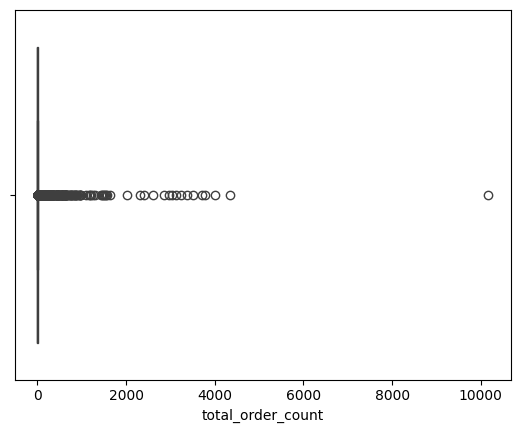

In [301]:
# общее число заказов
sns.boxplot(data=df_users_profile, x='total_order_count')
discribe_analysis(df_users_profile['total_order_count'], qnt=0.99)

- данные по количеству заказов имеют существенные выбросы. Для анализа можно отфильтровать выбросы

99.0 % значений менее 5.0
Минимальное значение:  1.0
Медиана:  2.75
Максимальное значение:  11.0
Размах:  10.0


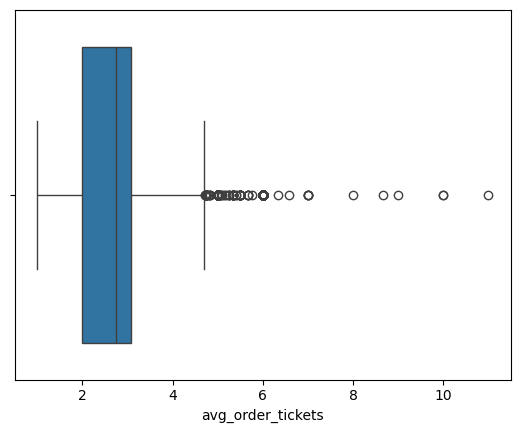

In [302]:
# среднее число билетов в заказе
sns.boxplot(data=df_users_profile, x='avg_order_tickets')
discribe_analysis(df_users_profile['avg_order_tickets'], qnt=0.99)

- данные по среднему числу билетов в заказе имеют выбросы

In [303]:
df_users_profile['avg_time_between_orders_days'] = df_users_profile['avg_time_between_orders'].dt.days

In [304]:
# среднее количество дней между покупками 
print('Доля пропусков: ', df_users_profile['avg_time_between_orders_days'].isna().sum() / len(df_users_profile))

Доля пропусков:  0.3829563146808316


- 38% пользователей заказали лишь один раз

95.0 % значений менее 61.0
Минимальное значение:  0.0
Медиана:  8.0
Максимальное значение:  148.0
Размах:  148.0


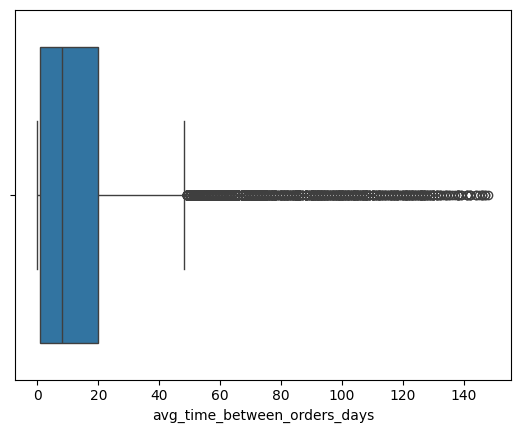

In [305]:
# среднее количество дней между покупками 
sns.boxplot(data=df_users_profile, x='avg_time_between_orders_days')
discribe_analysis(df_users_profile['avg_time_between_orders_days'], qnt=0.95)

- данные по количеству дней между покупками имеют выбросы.

### Промежуточный итог:

- общее число пользователей:  21838. Данных по объему достаточно для анализа
- общее число заказов содержит выбросы: Медиана:  2.0, 99.0 % значений менее 152. Присутствует аномальное значение: 10168.
- данные по среднему числу билетов в заказе имеют выбросы. Медиана:  2.75, 99.0 % значений менее 5. Максимальное значение:  11.
- 38% пользователей заказали лишь один раз
- данные по количеству дней между покупками имеют выбросы. Медиана:  8, 95.0 % значений менее 61. Максимальное значение:  148

### Работа с выбросами
Если вы найдёте аномальные значения, опишите их и примите обоснованное решение о том, как с ними поступить:

- Оставить и учитывать их при анализе?
- Отфильтровать данные по какому-то значению, например, по 95-му или 99-му перцентилю?

Если вы проведёте фильтрацию, то вычислите объём отфильтрованных данных и выведите статистические показатели по обновлённому датасету.

In [306]:
# фиксация размера датасета до фильтрации
prev_size = len(df_users_profile)

Данные по **количеству заказов** стоит отфильтровать по 99 перцентилю. 
- Возможно, выбросы связаны с наличием корпоративных клиентов (организации, юридические лица). Они делают массовые заказы на группу людей. Анализ таких клиентов в рамках настоящего исследования нас не интересует, так что можно их отфильтровать.

In [307]:
df_users_profile = df_users_profile.drop(df_users_profile[df_users_profile['total_order_count'] > df_users_profile['total_order_count'].quantile(0.99)].index)

**Данные по среднему числу билетов** в заказе имеют выбросы. Экстремальных значений довольно мало. Можно отфильтровать по 99 перцентилю без существенных искажений

In [308]:
df_users_profile = df_users_profile.drop(df_users_profile[df_users_profile['avg_order_tickets'] > df_users_profile['avg_order_tickets'].quantile(0.99)].index)

**Данные по количеству дней между покупками** имеют выбросы. Экстремальные значения распределены по дианазону 61-148 достаточно равномерно. Можно пока оставить эти данные и потом учесть при анализе.

In [309]:
# анализ потерь
print('Потери при фильтрации: ', (prev_size - len(df_users_profile)) / prev_size * 100, '%') 

Потери при фильтрации:  1.877461305980401 %


In [310]:
# статистические данные по обновленному датасету
df_users_profile.describe()

,first_order_id,first_order_ts,order_ts,total_order_count,avg_order_revenue,avg_order_tickets,avg_time_between_orders,avg_time_between_orders_days
count,2.142800e+04,21428,21428,21428.000000,21428.000000,21428.000000,13196,13196.000000
mean,4.343117e+06,2024-08-11 02:07:20.435271680,2024-09-18 16:29:27.850895872,6.539248,543.009284,2.714772,16 days 04:44:45.738448774,15.798121
min,1.161000e+03,2024-06-01 00:01:58,2024-06-01 01:29:40,1.000000,0.000000,1.000000,0 days 00:00:01,0.000000
25%,2.230638e+06,2024-06-26 12:03:36.500000,2024-08-24 21:02:23,1.000000,210.537083,2.000000,1 days 10:43:10.522060943,1.000000
50%,4.320290e+06,2024-08-09 19:08:57.500000,2024-10-02 23:37:53.500000,2.000000,463.277500,2.750000,8 days 11:57:27.994485294,8.000000
75%,6.519788e+06,2024-09-23 11:19:15.249999872,2024-10-22 14:02:43.500000,5.000000,765.709976,3.000000,20 days 21:29:59.083333333,20.000000
max,8.652818e+06,2024-10-31 23:55:27,2024-10-31 23:59:54,152.000000,2628.421739,5.000000,148 days 05:27:58,148.000000
std,2.496602e+06,NaN,NaN,14.367341,430.304994,0.864846,22 days 09:43:14.413323664,22.333309


### Промежуточный итог:

- в ходе анализа распределения данных были выявлены выбросы в данных среди: количества заказов, среднего числа билетов, количества дней между покупками
- принято решение отфильтровать данные по 99 перцинтилю среди: количества заказов, среднего числа билетов
- выбросы по количеству дней между покупками необходимо учитвывать при дальнейшем анализе
- Потери при фильтрации:  1.88 %

---

### 4. Исследовательский анализ данных

Следующий этап — исследование признаков, влияющих на возврат пользователей, то есть на совершение повторного заказа. Для этого используйте профили пользователей.



#### 4.1. Исследование признаков первого заказа и их связи с возвращением на платформу

Исследуйте признаки, описывающие первый заказ пользователя, и выясните, влияют ли они на вероятность возвращения пользователя.

---

**Задача 4.1.1.** Изучите распределение пользователей по признакам.

- Сгруппируйте пользователей:
    - по типу их первого мероприятия;
    - по типу устройства, с которого совершена первая покупка;
    - по региону проведения мероприятия из первого заказа;
    - по билетному оператору, продавшему билеты на первый заказ.
- Подсчитайте общее количество пользователей в каждом сегменте и их долю в разрезе каждого признака. Сегмент — это группа пользователей, объединённых определённым признаком, то есть объединённые принадлежностью к категории. Например, все клиенты, сделавшие первый заказ с мобильного телефона, — это сегмент.
- Ответьте на вопрос: равномерно ли распределены пользователи по сегментам или есть выраженные «точки входа» — сегменты с наибольшим числом пользователей?

---


In [311]:
df_users_profile.head()

,user_id,first_order_device,first_order_id,first_order_ts,first_order_region_name,first_order_service_name,first_order_event_type_main,order_ts,total_order_count,avg_order_revenue,avg_order_tickets,avg_time_between_orders,is_two,is_five,avg_time_between_orders_days
0,0002849b70a3ce2,mobile,4359165,2024-08-20 16:08:03,каменевский_регион,край_билетов,театр,2024-08-20 16:08:03,1,1521.940000,4.000000,NaT,False,False,NaN
1,0005ca5e93f2cf4,mobile,7965605,2024-07-23 18:36:24,каменевский_регион,мой_билет,выставки,2024-10-06 13:56:02,2,774.010000,3.000000,74 days 19:19:38,True,False,74.0
2,000898990054619,mobile,1139875,2024-07-13 19:40:48,североярская_область,лови_билет,другое,2024-10-23 15:12:00,3,767.213333,2.666667,50 days 21:45:36,True,False,50.0
3,00096d1f542ab2b,desktop,6636941,2024-08-15 16:48:48,каменевский_регион,край_билетов,театр,2024-08-15 16:48:48,1,917.830000,4.000000,NaT,False,False,NaN
4,000a55a418c128c,mobile,4657981,2024-09-29 19:39:12,поленовский_край,лучшие_билеты,театр,2024-10-15 10:29:04,2,61.310000,1.500000,15 days 14:49:52,True,False,15.0


In [312]:
def plot_segment_share_dist(column_to_plot: pd.Series, title: str = ''):

    abs_counts = column_to_plot.value_counts()
    rel_counts = column_to_plot.value_counts(normalize=True)
    dist = pd.concat([abs_counts, rel_counts], axis=1)
    dist.columns = ['absolute', 'relative']

    print('Распределение по абсолютной и относительной величине:')
    print(dist)

    share = rel_counts.sort_values()

    ax = share.plot(
        kind='barh', figsize=(10, 6), color='cornflowerblue'
    )

    ax.set_ylabel('Категория')          
    ax.set_xlabel('Проценты')   
    ax.set_title(title)

    ax.xaxis.set_major_formatter(PercentFormatter(xmax=1))

    for i, v in enumerate(share.values):
        ax.text(v + 0.003, i, f'{v:.1%}', va='center', fontsize=9)

    plt.tight_layout()
    plt.show()

Распределение по абсолютной и относительной величине:
                             absolute  relative
first_order_event_type_main                    
концерты                         9518  0.444185
другое                           5320  0.248273
театр                            4210  0.196472
стендап                          1096  0.051148
спорт                             779  0.036354
выставки                          410  0.019134
ёлки                               95  0.004433


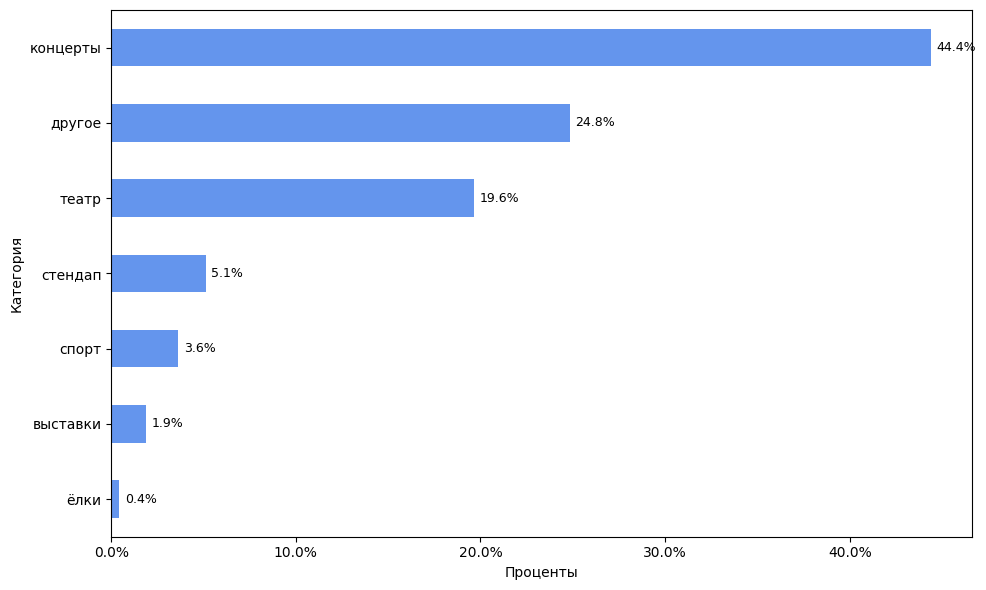

In [313]:
# группировка по типу первого мероприятия
plot_segment_share_dist(df_users_profile['first_order_event_type_main'])


- по типу первого мероприятия есть явный лидер: доля концертов 44.4%
- выделяется категория "другое" с 24.8% - это отсутствие информации о меропрятии
- существенная доля у театров: 19.6%
- по остальным категориям гораздо меньше клиентов: менее 6 процентов для каждой категории (стендапа, спорта, выставок, елок)

Распределение по абсолютной и относительной величине:
                    absolute  relative
first_order_device                    
mobile                 17751  0.828402
desktop                 3677  0.171598


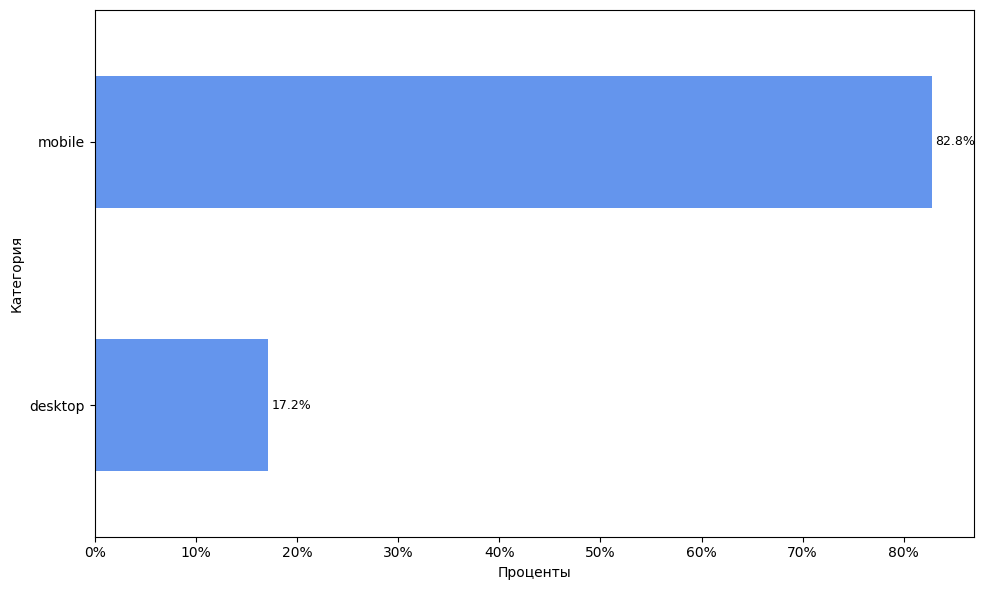

In [314]:
# группировка по типу утройства первого заказа
plot_segment_share_dist(df_users_profile['first_order_device'])

- с мобильных телефонов гораздо чаще делают первые заказы: 82.8% 


Суммарная доля малозначимых регионов:  0.08680231472839278
Распределение по абсолютной и относительной величине:
                           absolute  relative
first_order_region_name                      
каменевский_регион             7032  0.359362
североярская_область           3716  0.189902
широковская_область            1209  0.061785
озернинский_край                671  0.034291
малиновоярский_округ            522  0.026676
шанырский_регион                502  0.025654
травяная_область                484  0.024734
светополянский_округ            455  0.023252
речиновская_область             437  0.022332
яблоневская_область             406  0.020748
верхоречная_область             373  0.019062
медовская_область               369  0.018857
лугоградская_область            357  0.018244
серебринская_область            327  0.016711
тепляковская_область            321  0.016404
солнечнореченская_область       292  0.014922
солнечноземская_область         279  0.014258
горицветская_

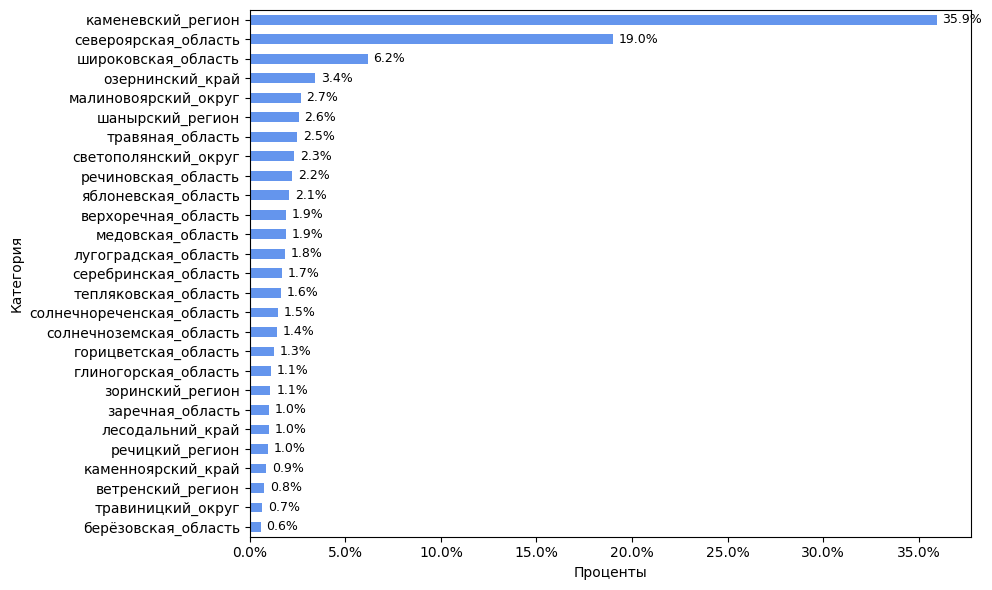

In [315]:
# группировка по региону проведения первого мероприятия
ordered_regions = df_users_profile['first_order_region_name'].value_counts(normalize=True).reset_index()

# фильтруем регионы, доля которых более threshold
threshold = 0.005
first_order_region_name_significant = ordered_regions[ordered_regions['proportion'] > threshold]
print('Суммарная доля малозначимых регионов: ', ordered_regions[ordered_regions['proportion'] <= threshold]['proportion'].sum())

first_region_name = df_users_profile[df_users_profile['first_order_region_name'].isin(first_order_region_name_significant['first_order_region_name'].unique().tolist())]

plot_segment_share_dist(first_region_name['first_order_region_name'])

- для отображения наиболее значимых регионов применена фильтрация: регионы с долей менее 0.5% составляют 8.6% от общего количества 
- лидеры среди значимх районов (с долей более 0.5% в общем датасете): 
    - каменевский_регион 36%
    - североярская_область 19%
    - широковская_область  6%

Распределение по абсолютной и относительной величине:
                          absolute  relative
first_order_service_name                    
билеты_без_проблем            5096  0.237820
мой_билет                     2948  0.137577
лови_билет                    2790  0.130203
билеты_в_руки                 2536  0.118350
облачко                       2166  0.101083
весь_в_билетах                1275  0.059502
лучшие_билеты                 1171  0.054648
прачечная                      579  0.027021
край_билетов                   452  0.021094
дом_культуры                   353  0.016474
яблоко                         316  0.014747
тебе_билет                     304  0.014187
городской_дом_культуры         213  0.009940
мир_касс                       210  0.009800
за_билетом                     197  0.009194
быстробилет                    160  0.007467
show_ticket                    157  0.007327
выступленияру                   94  0.004387
восьмёрка                       85  0.003967
б

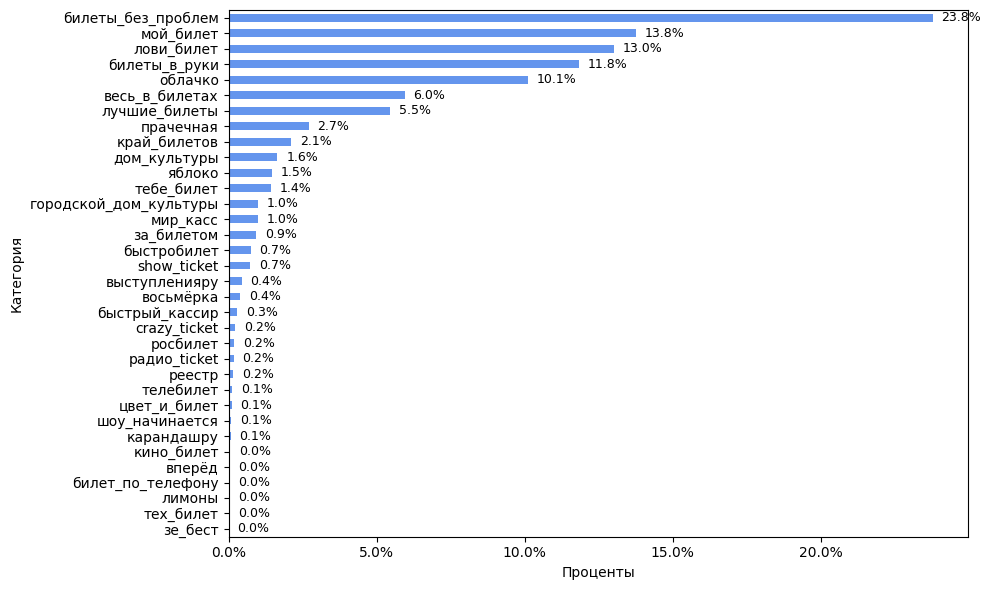

In [316]:
# по билетному оператору
plot_segment_share_dist(df_users_profile['first_order_service_name'])

- лидеры по билетному оператору:
    - билеты_без_проблем 23%
    - мой_билет 13%
    - лови_билет 13%
    - билеты_в_руки 11%
    - облачко 10%
- остальные не более 6% 

### Промежуточный итог:

пользователи распределены по сегментам **неравномерно**. Присутствуют явные точки входа: 
- по типу первого мероприятия есть явный лидер: доля **концертов** 44.4%
- по устройствам: 
    - **мобильные телефоны** 82.8% 
- по районам: 
    - **каменевский_регион** 36%, 
    - североярская_область 19%, 
    - широковская_область  6%
- по билетному оператору:
    - **билеты_без_проблем** 23%
    - мой_билет 13%
    - лови_билет 13%
    - билеты_в_руки 11%
    - облачко 10%

---

**Задача 4.1.2.** Проанализируйте возвраты пользователей:

- Для каждого сегмента вычислите долю пользователей, совершивших два и более заказа.
- Визуализируйте результат подходящим графиком. Если сегментов слишком много, то поместите на график только 10 сегментов с наибольшим количеством пользователей. Такое возможно с сегментами по региону и по билетному оператору.
- Ответьте на вопросы:
    - Какие сегменты пользователей чаще возвращаются на Яндекс Афишу?
    - Наблюдаются ли успешные «точки входа» — такие сегменты, в которых пользователи чаще совершают повторный заказ, чем в среднем по выборке?

При интерпретации результатов учитывайте размер сегментов: если в сегменте мало пользователей (например, десятки), то доли могут быть нестабильными и недостоверными, то есть показывать широкую вариацию значений.

---


In [317]:
def show_category_parts(df_to_analyse: pd.DataFrame, colname_groupby: str, part_category: str, title: str = '', df_init: pd.DataFrame | None = None):
    df_unstack = df_to_analyse.groupby(colname_groupby)[part_category].value_counts(normalize=True).unstack(fill_value=0)

    if True in df_unstack.columns:
        sort_col = True
    elif 1 in df_unstack.columns:
        sort_col = 1
    else:
        sort_col = df_unstack.columns[0]

    df_unstack = df_unstack.sort_values(by=sort_col, ascending=False)
    print(df_unstack)

    if df_init is not None:
        df_init_unstack = df_init.groupby(colname_groupby)[part_category].value_counts(normalize=True).unstack(fill_value=0)
        mean_share = df_init_unstack[sort_col].mean()
    else:
        mean_share = df_unstack[sort_col].mean()
    print(f'Средняя доля по "{sort_col}": {mean_share:.1%}')


    ax = df_unstack.plot(kind='bar')
    ax.axhline(mean_share, color='tomato', linestyle='--', linewidth=1.5, label='Среднее по выборке')


    plt.title(title)
    plt.ylabel('Доля') 
    plt.xlabel('Категория') 
    plt.xticks(rotation=45)  
    plt.legend()  

    # Отображаем график
    plt.show()

is_two                          False     True 
first_order_event_type_main                    
выставки                     0.358537  0.641463
театр                        0.362470  0.637530
концерты                     0.380857  0.619143
стендап                      0.387774  0.612226
другое                       0.399248  0.600752
спорт                        0.440308  0.559692
ёлки                         0.442105  0.557895
Средняя доля по "True": 60.4%


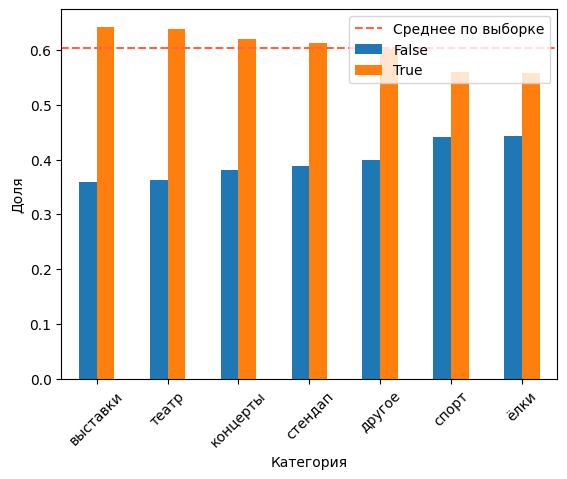

In [318]:
show_category_parts(df_users_profile, colname_groupby='first_order_event_type_main', part_category='is_two')

- доля пользователей с 2мя и более заказами выше среднего для: выставок, театров, концертов, стендапов (от 61% до 64%)


is_two                 False     True 
first_order_device                    
desktop             0.358716  0.641284
mobile              0.389443  0.610557
Средняя доля по "True": 62.6%


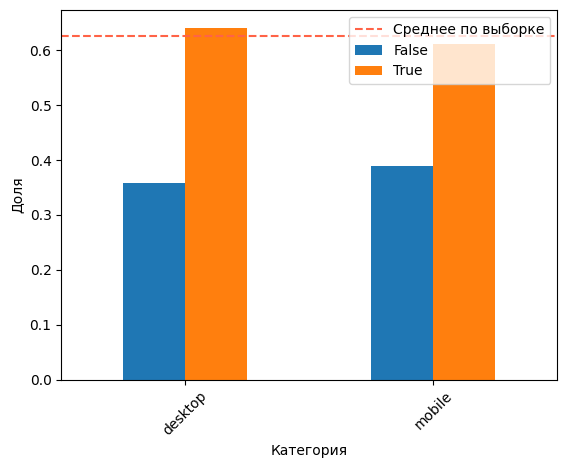

In [319]:
show_category_parts(df_users_profile, colname_groupby='first_order_device', part_category='is_two')

- доля пользователей с 2ми и более заказами среди устройств выше для компьютеров 64%, но не существенно. Для мобильных составляет 61%

is_two                      False     True 
first_order_region_name                    
шанырский_регион         0.326693  0.673307
светополянский_округ     0.342857  0.657143
широковская_область      0.350703  0.649297
североярская_область     0.358450  0.641550
речиновская_область      0.366133  0.633867
каменевский_регион       0.373720  0.626280
травяная_область         0.382231  0.617769
яблоневская_область      0.399015  0.600985
малиновоярский_округ     0.442529  0.557471
озернинский_край         0.444113  0.555887
Средняя доля по "True": 55.9%


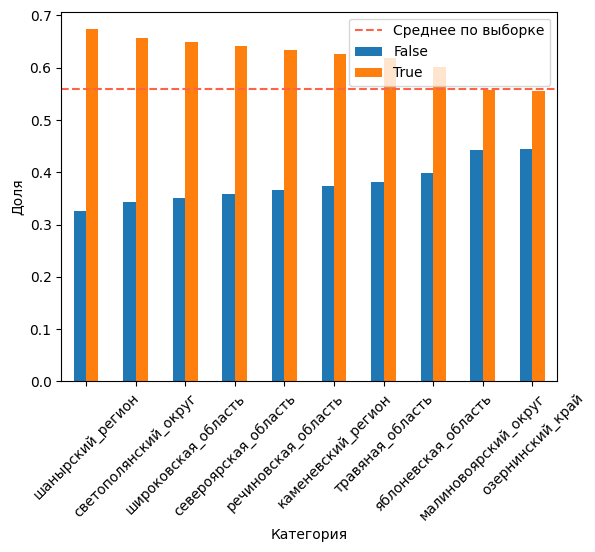

In [320]:
ordered_regions = df_users_profile['first_order_region_name'].value_counts(normalize=True).reset_index().sort_values(by='proportion', ascending=False)

top_regions = ordered_regions.head(10)['first_order_region_name'].tolist()
first_region_name_top_regions = df_users_profile[df_users_profile['first_order_region_name'].isin(top_regions)]

show_category_parts(first_region_name_top_regions, colname_groupby='first_order_region_name', part_category='is_two', df_init=df_users_profile)

- cреди регионов выделяются (доля более 60%):
    - шанырский_регион         67%
    - светополянский_округ     65%
    - широковская_область      64%
    - североярская_область     64%
    - речиновская_область      63%
    - каменевский_регион       62%
    - травяная_область         61%
    - яблоневская_область      60%

- Средняя доля по выборке: 55.9%

is_two                       False     True 
first_order_service_name                    
дом_культуры              0.348442  0.651558
край_билетов              0.349558  0.650442
весь_в_билетах            0.369412  0.630588
билеты_в_руки             0.370662  0.629338
прачечная                 0.371330  0.628670
лучшие_билеты             0.382579  0.617421
облачко                   0.386427  0.613573
лови_билет                0.387455  0.612545
мой_билет                 0.390434  0.609566
билеты_без_проблем        0.392268  0.607732
Средняя доля по "True": 61.7%


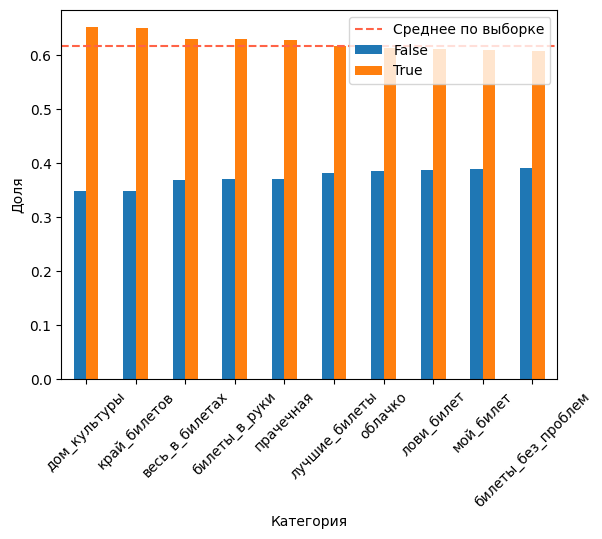

In [321]:
# по билетному оператору
ordered_service_name = df_users_profile['first_order_service_name'].value_counts(normalize=True).reset_index().sort_values(by='proportion', ascending=False)
top_service_name = ordered_service_name.head(10)['first_order_service_name'].tolist()
first_order_service_name_top = df_users_profile[df_users_profile['first_order_service_name'].isin(top_service_name)]

show_category_parts(first_order_service_name_top, colname_groupby='first_order_service_name', part_category='is_two', df_init=df_users_profile)


- лидеры среди билетных операторов:
    - дом_культуры  65%
    - край_билетов  65%
    - весь_в_билетах 63%
    - билеты_в_руки  63%
    - прачечная 63%
- Средняя доля по выборке: 61.7%

### Промежуточные выводы:

Сегменты пользователей, которые чаще возвращаются на Яндекс Афишу:
- пользователи, посетившие в первый раз: выставоку, театр, концерт, стендап (доля повторных заказов от 61% до 64%, что выше среднего по выборке)
- пользователи, совершившие покупку с компьютеров 64% (выше среднего по выборке), возвращаются чаще, чем с мобильных 61%
- пользователи, по посетившие в первый раз из регионов (указан процент пользователей с повторной покупкой, выше средней доле по выборке: 55.9%):
    - шанырский_регион         67%
    - светополянский_округ     65%
    - широковская_область      64%
    - североярская_область     64%
    - речиновская_область      63%
    - каменевский_регион       62%
    - травяная_область         61%
    - яблоневская_область      60%

- пользователи, воспользовавшиеся билетными операторами (указан процент пользователей с повторной покупкой, выше средней доле по выборке: 61.7%):
    - дом_культуры  65%
    - край_билетов  65%
    - весь_в_билетах 63%
    - билеты_в_руки  63%
    - прачечная 63%


---

**Задача 4.1.3.** Опираясь на выводы из задач выше, проверьте продуктовые гипотезы:

- **Гипотеза 1.** Тип мероприятия влияет на вероятность возврата на Яндекс Афишу: пользователи, которые совершили первый заказ на спортивные мероприятия, совершают повторный заказ чаще, чем пользователи, оформившие свой первый заказ на концерты.
- **Гипотеза 2.** В регионах, где больше всего пользователей посещают мероприятия, выше доля повторных заказов, чем в менее активных регионах.

---

- исходя из анализа выше, **Гипотеза 1 неверна**: доля повторных заказов при первом посещении концерта 64% > спортивного меропрятия 56%

In [322]:
# проверка 2ой гипотезы:
ordered_regions = df_users_profile['first_order_region_name'].value_counts().reset_index().sort_values(by='count', ascending=False)
ordered_regions


,first_order_region_name,count
0,каменевский_регион,7032
1,североярская_область,3716
2,широковская_область,1209
3,озернинский_край,671
4,малиновоярский_округ,522
...,...,...
76,светолесский_край,2
77,тихогорская_область,2
78,сосноводолинская_область,1
79,яснопольский_округ,1


In [323]:
top_regions_is_two = df_users_profile.groupby('first_order_region_name')['is_two'].value_counts(normalize=True).unstack(fill_value=0).reset_index()
df_to_analyse = pd.merge(ordered_regions, top_regions_is_two, on='first_order_region_name')
df_to_analyse[['count', True]].corr(method='spearman')

,count,True
count,1.000000,0.312013
True,0.312013,1.000000


- **Гипотеза 2 неверна**: общая посещаемость мероприятий имеет малую положительную связь с долей повторных визитов в регионах

---

#### 4.2. Исследование поведения пользователей через показатели выручки и состава заказа

Изучите количественные характеристики заказов пользователей, чтобы узнать среднюю выручку сервиса с заказа и количество билетов, которое пользователи обычно покупают.

Эти метрики важны не только для оценки выручки, но и для оценки вовлечённости пользователей. Возможно, пользователи с более крупными и дорогими заказами более заинтересованы в сервисе и поэтому чаще возвращаются.

---

**Задача 4.2.1.** Проследите связь между средней выручкой сервиса с заказа и повторными заказами.

- Постройте сравнительные гистограммы распределения средней выручки с билета (`avg_revenue_rub`):
    - для пользователей, совершивших один заказ;
    - для вернувшихся пользователей, совершивших 2 и более заказа.
- Ответьте на вопросы:
    - В каких диапазонах средней выручки концентрируются пользователи из каждой группы?
    - Есть ли различия между группами?

Текст на сером фоне:
    
**Рекомендация:**

1. Используйте одинаковые интервалы (`bins`) и прозрачность (`alpha`), чтобы визуально сопоставить распределения.
2. Задайте параметру `density` значение `True`, чтобы сравнивать форму распределений, даже если число пользователей в группах отличается.

---


In [324]:
df_users_profile.head()

,user_id,first_order_device,first_order_id,first_order_ts,first_order_region_name,first_order_service_name,first_order_event_type_main,order_ts,total_order_count,avg_order_revenue,avg_order_tickets,avg_time_between_orders,is_two,is_five,avg_time_between_orders_days
0,0002849b70a3ce2,mobile,4359165,2024-08-20 16:08:03,каменевский_регион,край_билетов,театр,2024-08-20 16:08:03,1,1521.940000,4.000000,NaT,False,False,NaN
1,0005ca5e93f2cf4,mobile,7965605,2024-07-23 18:36:24,каменевский_регион,мой_билет,выставки,2024-10-06 13:56:02,2,774.010000,3.000000,74 days 19:19:38,True,False,74.0
2,000898990054619,mobile,1139875,2024-07-13 19:40:48,североярская_область,лови_билет,другое,2024-10-23 15:12:00,3,767.213333,2.666667,50 days 21:45:36,True,False,50.0
3,00096d1f542ab2b,desktop,6636941,2024-08-15 16:48:48,каменевский_регион,край_билетов,театр,2024-08-15 16:48:48,1,917.830000,4.000000,NaT,False,False,NaN
4,000a55a418c128c,mobile,4657981,2024-09-29 19:39:12,поленовский_край,лучшие_билеты,театр,2024-10-15 10:29:04,2,61.310000,1.500000,15 days 14:49:52,True,False,15.0


In [325]:
# средняя выручка с билета
df_users_profile['avg_revenue_rub'] = df_users_profile['avg_order_revenue'] / df_users_profile['avg_order_tickets']

<Axes: xlabel='avg_revenue_rub', ylabel='Density'>

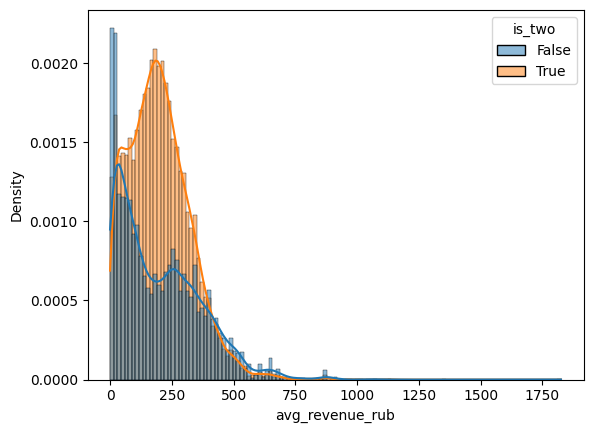

In [326]:
sns.histplot(data=df_users_profile, x='avg_revenue_rub', hue='is_two', kde=True, stat='density')

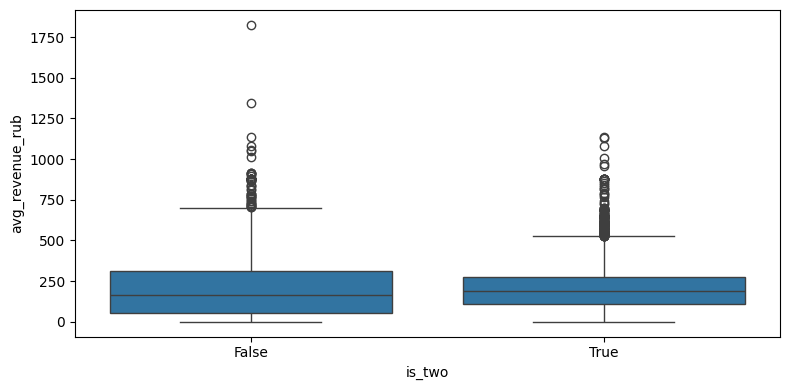

In [327]:
fig, ax = plt.subplots(figsize=(8, 4))
sns.boxplot(data=df_users_profile, x='is_two', y='avg_revenue_rub', ax=ax)
ax.set_xlabel('is_two')
ax.set_ylabel('avg_revenue_rub')
plt.tight_layout()
plt.show()

In [328]:
# диапазоны концентрации: межквартильный размах (Q1–Q3) по группам is_two
q = df_users_profile.groupby('is_two')['avg_revenue_rub'].quantile([0.25, 0.5, 0.75]).unstack()
q.columns = ['Q1', 'median', 'Q3']
print('Значения выручки концентрируется в диапазонах')
print(q)
print('-'* 100)
q_median_rel_diff = (q['median'].max() - q['median'].min()) / q['median'].max() * 100
print('Относитальное изменение медианного значения выручки: ', q_median_rel_diff)
print('Q1-Q3 квантильный размах: ', abs((q['Q3'] - q['Q1']).diff() / (q['Q3'] - q['Q1']).max()) * 100 )

Значения выручки концентрируется в диапазонах
                Q1      median          Q3
is_two                                    
False    56.760000  165.715000  313.355417
True    106.902846  189.456994  275.671500
----------------------------------------------------------------------------------------------------
Относитальное изменение медианного значения выручки:  12.531600712588281
Q1-Q3 квантильный размах:  is_two
False          NaN
True     34.227721
dtype: float64


### Промежуточный вывод:
- между группами средней выручки с билета (`avg_revenue_rub`) есть отличия: 
    - медианный чек для пользователей, сделавших более одного заказа выше на 12.5%
    - Q1-Q3 квантильный размах для пользователей, сделавших более одного заказа меньше на 34%. То есть распределение более кучное и симметричное для клиентов с большим количеством заказов

---

**Задача 4.2.2.** Сравните распределение по средней выручке с заказа в двух группах пользователей:

- совершившие 2–4 заказа;
- совершившие 5 и более заказов.

Ответьте на вопрос: есть ли различия по значению средней выручки с заказа между пользователями этих двух групп?

---


In [329]:
# совершившие 2-4 заказа
df_users_profile_2_4 = df_users_profile[(df_users_profile['is_two'] == True) & (df_users_profile['is_five'] == False)]
df_users_profile_2_4.head()

,user_id,first_order_device,first_order_id,first_order_ts,first_order_region_name,first_order_service_name,first_order_event_type_main,order_ts,total_order_count,avg_order_revenue,avg_order_tickets,avg_time_between_orders,is_two,is_five,avg_time_between_orders_days,avg_revenue_rub
1,0005ca5e93f2cf4,mobile,7965605,2024-07-23 18:36:24,каменевский_регион,мой_билет,выставки,2024-10-06 13:56:02,2,774.010000,3.000000,74 days 19:19:38,True,False,74.0,258.003333
2,000898990054619,mobile,1139875,2024-07-13 19:40:48,североярская_область,лови_билет,другое,2024-10-23 15:12:00,3,767.213333,2.666667,50 days 21:45:36,True,False,50.0,287.705000
4,000a55a418c128c,mobile,4657981,2024-09-29 19:39:12,поленовский_край,лучшие_билеты,театр,2024-10-15 10:29:04,2,61.310000,1.500000,15 days 14:49:52,True,False,15.0,40.873333
6,00147c9209d45d3,mobile,4361340,2024-06-25 23:26:58,каменевский_регион,облачко,концерты,2024-06-25 23:28:52,2,352.945000,1.500000,0 days 00:01:54,True,False,0.0,235.296667
9,001e7037d013f0f,mobile,1673330,2024-07-04 08:06:44,златопольский_округ,мой_билет,другое,2024-09-29 22:58:14,3,326.623333,1.333333,43 days 19:25:45,True,False,43.0,244.967500


In [330]:
# совершившие >=5 заказов
df_users_profile_5 = df_users_profile[(df_users_profile['is_five'] == True)]
df_users_profile_5.head()

,user_id,first_order_device,first_order_id,first_order_ts,first_order_region_name,first_order_service_name,first_order_event_type_main,order_ts,total_order_count,avg_order_revenue,avg_order_tickets,avg_time_between_orders,is_two,is_five,avg_time_between_orders_days,avg_revenue_rub
5,000cf0659a9f40f,mobile,6818017,2024-06-20 10:35:26,широковская_область,лови_билет,концерты,2024-06-21 04:36:17,13,1175.808462,3.307692,0 days 01:30:04.250000,True,True,0.0,355.476977
13,002b75ca606ba46,desktop,4938817,2024-07-08 13:02:39,каменевский_регион,быстробилет,концерты,2024-10-16 18:57:09,6,443.580000,3.000000,20 days 01:10:54,True,True,20.0,147.860000
15,002ec276eee9b0b,mobile,7463760,2024-07-10 00:43:41,широковская_область,мой_билет,концерты,2024-10-31 13:17:33,22,811.942727,2.863636,5 days 09:44:28.190476190,True,True,5.0,283.535556
16,0033403583a55ed,mobile,4130529,2024-06-19 10:53:29,каменевский_регион,билеты_без_проблем,другое,2024-09-17 16:52:06,6,135.692294,1.666667,18 days 01:11:43.400000,True,True,18.0,81.415376
18,00345f897f95a34,mobile,5380110,2024-06-02 08:00:46,лесодальний_край,тебе_билет,концерты,2024-10-23 22:01:19,8,1338.258750,2.875000,20 days 12:17:13.285714285,True,True,20.0,465.481304


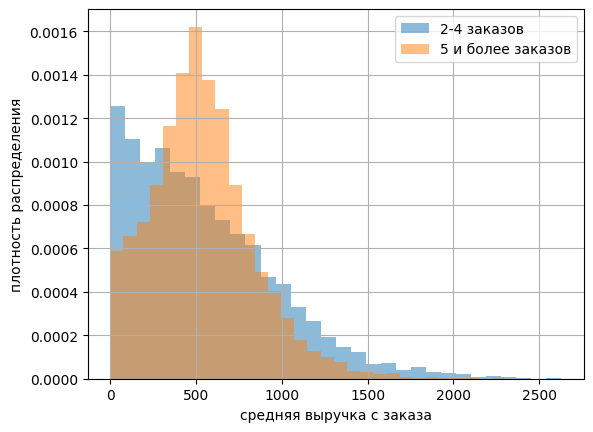

In [331]:
bins = 30
alpha=0.5
df_users_profile_2_4['avg_order_revenue'].hist(bins=bins, alpha=alpha, density=True, label='2-4 заказов')
df_users_profile_5['avg_order_revenue'].hist(bins=bins, alpha=alpha, density=True, label='5 и более заказов')
plt.xlabel('средняя выручка с заказа')
plt.ylabel('плотность распределения')
plt.legend()

In [332]:
df_users_profile_2_4['avg_order_revenue'].describe()

count    7090.000000
mean      550.009207
std       416.790512
min         0.000000
25%       218.755000
50%       471.040000
75%       797.547500
max      2628.421739
Name: avg_order_revenue, dtype: float64

In [333]:
df_users_profile_5['avg_order_revenue'].describe()

count    6106.000000
mean      535.857438
std       297.314368
min         0.000000
25%       331.683411
50%       513.088937
75%       700.601250
max      2299.869022
Name: avg_order_revenue, dtype: float64

In [334]:
mean_2_4 = df_users_profile_2_4['avg_order_revenue'].mean()
mean_5 = df_users_profile_5['avg_order_revenue'].mean()
q_median_rel_diff = (mean_2_4 - mean_5) / max(mean_5, mean_2_4) * 100
print('Относитальное изменение среднего значения выручки: ', q_median_rel_diff)

Относитальное изменение среднего значения выручки:  2.573005949559319


### Промежуточные выводы:
- существенного различия по величине выручки с заказа между категориями (2-4 заказов) и (5 и более заказов) нет: 
    - Относитальное изменение среднего значения выручки:  2.5%

---

**Задача 4.2.3.** Проанализируйте влияние среднего количества билетов в заказе на вероятность повторной покупки.

- Изучите распределение пользователей по среднему количеству билетов в заказе (`avg_tickets_count`) и опишите основные наблюдения.
- Разделите пользователей на несколько сегментов по среднему количеству билетов в заказе:
    - от 1 до 2 билетов;
    - от 2 до 3 билетов;
    - от 3 до 5 билетов;
    - от 5 и более билетов.
- Для каждого сегмента подсчитайте общее число пользователей и долю пользователей, совершивших повторные заказы.
- Ответьте на вопросы:
    - Как распределены пользователи по сегментам — равномерно или сконцентрировано?
    - Есть ли сегменты с аномально высокой или низкой долей повторных покупок?

---

In [335]:
df_users_profile.head()

,user_id,first_order_device,first_order_id,first_order_ts,first_order_region_name,first_order_service_name,first_order_event_type_main,order_ts,total_order_count,avg_order_revenue,avg_order_tickets,avg_time_between_orders,is_two,is_five,avg_time_between_orders_days,avg_revenue_rub
0,0002849b70a3ce2,mobile,4359165,2024-08-20 16:08:03,каменевский_регион,край_билетов,театр,2024-08-20 16:08:03,1,1521.940000,4.000000,NaT,False,False,NaN,380.485000
1,0005ca5e93f2cf4,mobile,7965605,2024-07-23 18:36:24,каменевский_регион,мой_билет,выставки,2024-10-06 13:56:02,2,774.010000,3.000000,74 days 19:19:38,True,False,74.0,258.003333
2,000898990054619,mobile,1139875,2024-07-13 19:40:48,североярская_область,лови_билет,другое,2024-10-23 15:12:00,3,767.213333,2.666667,50 days 21:45:36,True,False,50.0,287.705000
3,00096d1f542ab2b,desktop,6636941,2024-08-15 16:48:48,каменевский_регион,край_билетов,театр,2024-08-15 16:48:48,1,917.830000,4.000000,NaT,False,False,NaN,229.457500
4,000a55a418c128c,mobile,4657981,2024-09-29 19:39:12,поленовский_край,лучшие_билеты,театр,2024-10-15 10:29:04,2,61.310000,1.500000,15 days 14:49:52,True,False,15.0,40.873333


<Axes: xlabel='avg_order_tickets', ylabel='Density'>

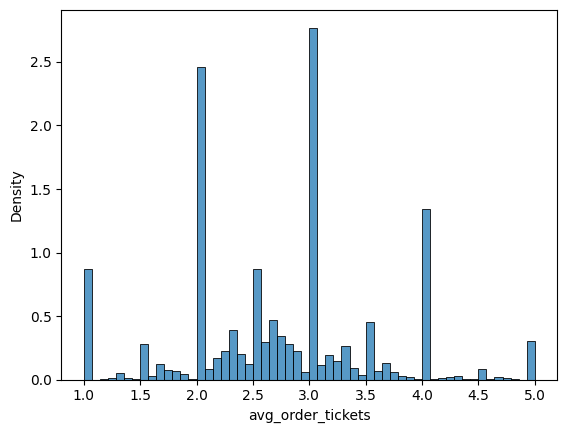

In [336]:
sns.histplot(data=df_users_profile, x='avg_order_tickets', stat='density')

- распределение среднего количества билетов в заказе имеет явные пики в значениях: 1, 2, 2.5, 3, 4, 5

In [337]:
# сегментация по avg_order_tickets и расчет доли повторных заказов
bins = [1, 2, 3, 5, float('inf')]
labels = ['1–2', '2–3', '3–5', '5+']

segmented = df_users_profile.copy()
segmented['tickets_segment'] = pd.cut(segmented['avg_order_tickets'], bins=bins, labels=labels, right=True, include_lowest=True)
segmented
segment_stats = (
    segmented.groupby('tickets_segment')
    .agg(total_users=('user_id', 'nunique'),
         repeat_users=('is_two', 'sum'),
         repeat_share=('is_two', 'mean'))
    .reset_index()
)
segment_stats['total_users_share'] = segment_stats['total_users'] / segment_stats['total_users'].sum()

print(segment_stats)



  tickets_segment  total_users  repeat_users  repeat_share  total_users_share
0             1–2         6150          2467      0.401138           0.287008
1             2–3         9922          7368      0.742592           0.463039
2             3–5         5356          3361      0.627521           0.249953
3              5+            0             0           NaN           0.000000


/var/folders/fv/jb9qsjkd4_b_sx1z7304t_lr0000gn/T/ipykernel_34528/3958839320.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  segmented.groupby('tickets_segment')


### Промежуточный вывод:

- Как распределены пользователи по сегментам — равномерно или сконцентрировано?
- Есть ли сегменты с аномально высокой или низкой долей повторных покупок?
Сегментация:
- большая часть пользователей сконцентрирована в сегменте 2–3 среднего билета в заказе: 46%
- сегменты 1–2 и 3–5 близки до доле: 29% и 25%
- сегмент 5 и более в данных не встречается

Доля повторных покупок в сегментах:
- в сегменте 2–3 доля высокая: 74%
- в сегменте 1-2 доля низкая: 40%

---

#### 4.3. Исследование временных характеристик первого заказа и их влияния на повторные покупки

Изучите временные параметры, связанные с первым заказом пользователей:

- день недели первой покупки;
- время с момента первой покупки — лайфтайм;
- средний интервал между покупками пользователей с повторными заказами.

---

**Задача 4.3.1.** Проанализируйте, как день недели, в которой была совершена первая покупка, влияет на поведение пользователей.

- По данным даты первого заказа выделите день недели.
- Для каждого дня недели подсчитайте общее число пользователей и долю пользователей, совершивших повторные заказы. Результаты визуализируйте.
- Ответьте на вопрос: влияет ли день недели, в которую совершена первая покупка, на вероятность возврата клиента?

---


In [338]:
df_users_profile.head()

,user_id,first_order_device,first_order_id,first_order_ts,first_order_region_name,first_order_service_name,first_order_event_type_main,order_ts,total_order_count,avg_order_revenue,avg_order_tickets,avg_time_between_orders,is_two,is_five,avg_time_between_orders_days,avg_revenue_rub
0,0002849b70a3ce2,mobile,4359165,2024-08-20 16:08:03,каменевский_регион,край_билетов,театр,2024-08-20 16:08:03,1,1521.940000,4.000000,NaT,False,False,NaN,380.485000
1,0005ca5e93f2cf4,mobile,7965605,2024-07-23 18:36:24,каменевский_регион,мой_билет,выставки,2024-10-06 13:56:02,2,774.010000,3.000000,74 days 19:19:38,True,False,74.0,258.003333
2,000898990054619,mobile,1139875,2024-07-13 19:40:48,североярская_область,лови_билет,другое,2024-10-23 15:12:00,3,767.213333,2.666667,50 days 21:45:36,True,False,50.0,287.705000
3,00096d1f542ab2b,desktop,6636941,2024-08-15 16:48:48,каменевский_регион,край_билетов,театр,2024-08-15 16:48:48,1,917.830000,4.000000,NaT,False,False,NaN,229.457500
4,000a55a418c128c,mobile,4657981,2024-09-29 19:39:12,поленовский_край,лучшие_билеты,театр,2024-10-15 10:29:04,2,61.310000,1.500000,15 days 14:49:52,True,False,15.0,40.873333


In [339]:
# сегментация по дням недели первого заказа и доля повторных заказов
segmented = df_users_profile.copy()
segmented['first_order_ts'] = pd.to_datetime(segmented['first_order_ts'], errors='coerce')
segmented['weekday'] = segmented['first_order_ts'].dt.day_name()

weekday_stats = (
    segmented.groupby('weekday')
    .agg(total_users=('user_id', 'nunique'),
         repeat_users=('is_two', 'sum'),
         repeat_share=('is_two', 'mean'))
    .reset_index()
)

weekday_order = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
weekday_stats['weekday'] = pd.Categorical(weekday_stats['weekday'], categories=weekday_order, ordered=True)
weekday_stats = weekday_stats.sort_values('weekday')

print(weekday_stats)

     weekday  total_users  repeat_users  repeat_share
1     Monday         2894          1827      0.631306
5    Tuesday         3144          1952      0.620865
6  Wednesday         3031          1896      0.625536
4   Thursday         3086          1841      0.596565
0     Friday         3230          1940      0.600619
2   Saturday         3295          2077      0.630349
3     Sunday         2748          1663      0.605167


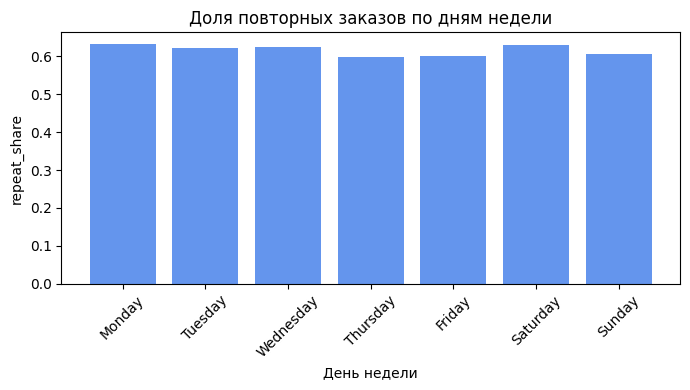

In [340]:
# bar chart: дни недели по x, repeat_share по y
fig, ax = plt.subplots(figsize=(7, 4))
ax.bar(weekday_stats['weekday'].astype(str), weekday_stats['repeat_share'], color='cornflowerblue')
ax.set_title('Доля повторных заказов по дням недели')
ax.set_xlabel('День недели')
ax.set_ylabel('repeat_share')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [341]:
weekday_stats['repeat_share'].describe()

count    7.000000
mean     0.615773
std      0.014640
min      0.596565
25%      0.602893
50%      0.620865
75%      0.627943
max      0.631306
Name: repeat_share, dtype: float64

In [342]:
(weekday_stats['repeat_share'].max() - weekday_stats['repeat_share'].min()) / weekday_stats['repeat_share'].max() * 100

np.float64(5.50303806834971)

### Промежуточный итог:
- день недели первой покупки не вляет на долю повторных заказов: средняя доля 0.61, относительный разброс по значению доли 5.5%

---

**Задача 4.3.2.** Изучите, как средний интервал между заказами влияет на удержание клиентов.

- Рассчитайте среднее время между заказами для двух групп пользователей:
    - совершившие 2–4 заказа;
    - совершившие 5 и более заказов.
- Исследуйте, как средний интервал между заказами влияет на вероятность повторного заказа, и сделайте выводы.

---


In [343]:
# среднее время между заказами по сегментам (2–4 заказов и 5+ заказов)
segmented = df_users_profile.copy()
segmented = segmented[segmented['total_order_count'] >= 2]

segmented['orders_segment'] = segmented['total_order_count'].apply(
    lambda x: '2–4' if 2 <= x <= 4 else '5+' if x >= 5 else None
)

segment_stats = (
    segmented.groupby('orders_segment')
    .agg(total_users=('user_id', 'nunique'),
         avg_time_between_orders_days=('avg_time_between_orders_days', 'mean'))
    .reset_index()
)

print(segment_stats)

  orders_segment  total_users  avg_time_between_orders_days
0            2–4         7090                     21.210014
1             5+         6106                      9.514085


### Промежуточный вывод:
- для сегмента 2–4 заказа среднее время 21 дня между заказами
- для сегмента 5+ заказов среднее время 9.5 дня между заказами
- Значит, чем меньше средний интервал между заказами, тем более вероятно заказ будет сделан повторно


---

#### 4.4. Корреляционный анализ количества покупок и признаков пользователя

Изучите, какие характеристики первого заказа и профиля пользователя могут быть связаны с числом покупок. Для этого используйте универсальный коэффициент корреляции `phi_k`, который позволяет анализировать как числовые, так и категориальные признаки.

---

**Задача 4.4.1:** Проведите корреляционный анализ:
- Рассчитайте коэффициент корреляции `phi_k` между признаками профиля пользователя и числом заказов (`total_orders`). При необходимости используйте параметр `interval_cols` для определения интервальных данных.
- Проанализируйте полученные результаты. Если полученные значения будут близки к нулю, проверьте разброс данных в `total_orders`. Такое возможно, когда в данных преобладает одно значение: в таком случае корреляционный анализ может показать отсутствие связей. Чтобы этого избежать, выделите сегменты пользователей по полю `total_orders`, а затем повторите корреляционный анализ. Выделите такие сегменты:
    - 1 заказ;
    - от 2 до 4 заказов;
    - от 5 и выше.
- Визуализируйте результат корреляции с помощью тепловой карты.
- Ответьте на вопрос: какие признаки наиболее связаны с количеством заказов?

---

In [344]:
df_users_profile.head()

,user_id,first_order_device,first_order_id,first_order_ts,first_order_region_name,first_order_service_name,first_order_event_type_main,order_ts,total_order_count,avg_order_revenue,avg_order_tickets,avg_time_between_orders,is_two,is_five,avg_time_between_orders_days,avg_revenue_rub
0,0002849b70a3ce2,mobile,4359165,2024-08-20 16:08:03,каменевский_регион,край_билетов,театр,2024-08-20 16:08:03,1,1521.940000,4.000000,NaT,False,False,NaN,380.485000
1,0005ca5e93f2cf4,mobile,7965605,2024-07-23 18:36:24,каменевский_регион,мой_билет,выставки,2024-10-06 13:56:02,2,774.010000,3.000000,74 days 19:19:38,True,False,74.0,258.003333
2,000898990054619,mobile,1139875,2024-07-13 19:40:48,североярская_область,лови_билет,другое,2024-10-23 15:12:00,3,767.213333,2.666667,50 days 21:45:36,True,False,50.0,287.705000
3,00096d1f542ab2b,desktop,6636941,2024-08-15 16:48:48,каменевский_регион,край_билетов,театр,2024-08-15 16:48:48,1,917.830000,4.000000,NaT,False,False,NaN,229.457500
4,000a55a418c128c,mobile,4657981,2024-09-29 19:39:12,поленовский_край,лучшие_билеты,театр,2024-10-15 10:29:04,2,61.310000,1.500000,15 days 14:49:52,True,False,15.0,40.873333


In [345]:
profile_features = [
    'first_order_device', 
    'first_order_region_name', 
    'first_order_service_name', 'first_order_event_type_main',
    'total_order_count', 'avg_order_revenue', 'avg_order_tickets', 'avg_revenue_rub','avg_time_between_orders_days', 
    'is_two', 'is_five'
    ]
numeric_columns = ['total_order_count', 'avg_order_revenue', 'avg_order_tickets', 'avg_revenue_rub','avg_time_between_orders_days']

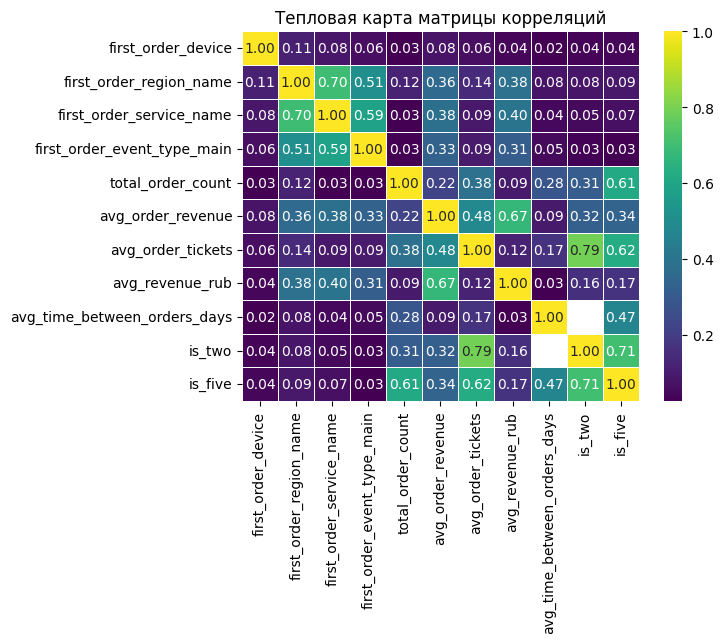

Корреляция переменных с 'total_order_count':
total_order_count               1.000000
is_five                         0.614441
avg_order_tickets               0.383913
is_two                          0.308478
avg_time_between_orders_days    0.284557
avg_order_revenue               0.219643
first_order_region_name         0.117353
avg_revenue_rub                 0.090951
first_order_event_type_main     0.028352
first_order_service_name        0.027352
first_order_device              0.027014
Name: total_order_count, dtype: float64


In [346]:
# Посчитаем матрицу корреляций
corr_matrix = df_users_profile[profile_features].phik_matrix(interval_cols=numeric_columns)

# Создаём тепловую  карту
sns.heatmap(data=corr_matrix, annot=True, fmt='.2f', linewidths=0.5, cmap='viridis')

# Показываем график с заголовком
plt.title('Тепловая карта матрицы корреляций')
plt.show()
print("Корреляция переменных с 'total_order_count':")
print(corr_matrix['total_order_count'].sort_values( ascending=False))

In [347]:
df_users_profile['total_order_count'].describe()

count    21428.000000
mean         6.539248
std         14.367341
min          1.000000
25%          1.000000
50%          2.000000
75%          5.000000
max        152.000000
Name: total_order_count, dtype: float64

- корреляция близка к 0, поскольку в 'total_order_count' много значений 1 заказа
- введем сегментацию

In [348]:
# сегментация по total_order_count

def segment_total_orders(x: int) -> str:
    if x == 1:
        return '1'
    if 2 <= x <= 4:
        return '2–4'
    return '5+'


df_users_profile['total_order_count_segment'] = df_users_profile['total_order_count'].apply(segment_total_orders)

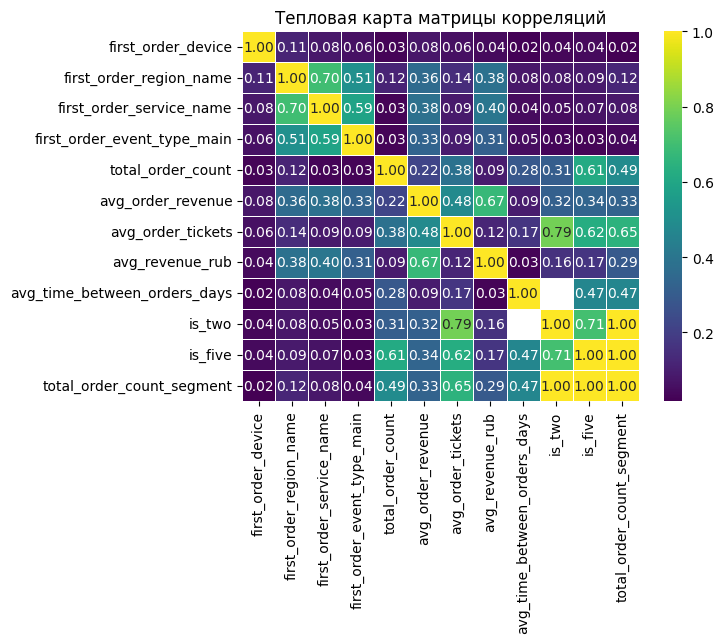

Корреляция переменных с 'total_order_count_segment':
is_two                          1.000000
is_five                         1.000000
total_order_count_segment       1.000000
avg_order_tickets               0.647372
total_order_count               0.487940
avg_time_between_orders_days    0.468247
avg_order_revenue               0.326120
avg_revenue_rub                 0.291908
first_order_region_name         0.124496
first_order_service_name        0.081904
first_order_event_type_main     0.040198
first_order_device              0.017635
Name: total_order_count_segment, dtype: float64


In [349]:
# Посчитаем матрицу корреляций
profile_features += ['total_order_count_segment']
corr_matrix = df_users_profile[profile_features].phik_matrix(interval_cols=numeric_columns)

# Создаём тепловую  карту
sns.heatmap(data=corr_matrix, annot=True, fmt='.2f', linewidths=0.5, cmap='viridis')

# Показываем график с заголовком
plt.title('Тепловая карта матрицы корреляций')
plt.show()
print("Корреляция переменных с 'total_order_count_segment':")
print(corr_matrix['total_order_count_segment'].sort_values( ascending=False))

### Промежуточный вывод:

- после проведения сегментации по количеству заказов (1 заказ; от 2 до 4 заказов; от 5 и выше.) можно отметить положительную корреляцию количества заказов со средним числом купленных билетов в одном заказе на уровне 0.64 (максимальная положительная связь именно с этим признаком). 

### 5. Общий вывод и рекомендации

В конце проекта напишите общий вывод и рекомендации: расскажите заказчику, на что нужно обратить внимание. В выводах кратко укажите:

- **Информацию о данных**, с которыми вы работали, и то, как они были подготовлены: например, расскажите о фильтрации данных, переводе тенге в рубли, фильтрации выбросов.
- **Основные результаты анализа.** Например, укажите:
    - Сколько пользователей в выборке? Как распределены пользователи по числу заказов? Какие ещё статистические показатели вы подсчитали важным во время изучения данных?
    - Какие признаки первого заказа связаны с возвратом пользователей?
    - Как связаны средняя выручка и количество билетов в заказе с вероятностью повторных покупок?
    - Какие временные характеристики влияют на удержание (день недели, интервалы между покупками)?
    - Какие характеристики первого заказа и профиля пользователя могут быть связаны с числом покупок согласно результатам корреляционного анализа?
- Дополните выводы информацией, которая покажется вам важной и интересной. Следите за общим объёмом выводов — они должны быть компактными и ёмкими.

В конце предложите заказчику рекомендации о том, как именно действовать в его ситуации. Например, укажите, на какие сегменты пользователей стоит обратить внимание в первую очередь, а какие нуждаются в дополнительных маркетинговых усилиях.

### Общий вывод и рекомендации:

**Данные и подготовка**
- Типы данных соответствуют описанию, выгрузка из SQL прошла успешно.
- Пропуски есть только в `days_since_prev` (7.5%) — оставлены без удаления.
- В `revenue` и `revenue_rub` выявлены отрицательные значения (<0.2%) — строки удалены.
- Отсутствующая информация: `event_type_main` — 22.6%.
- Проведено понижение размерностей в `order_id`, `tickets_count`, `event_id`, `days_since_prev`, `revenue`, `revenue_rub`. Уменьшена избыточность `order_dt`.
- Нормализация тестовых данных в `region_name`, `city_name`, `service_name`.
- Добавлен столбец `revenue_rub`.
- Обнаружены выбросы в `revenue_rub`, `tickets_count`, `days_since_prev`. Фильтрация по 99‑му перцентилю для `revenue_rub` дала потери 0.97%. В профиле пользователя дополнительно отфильтрованы выбросы по 99‑му перцентилю для количества заказов и среднего числа билетов, потери 1.88%. Выбросы по `days_since_prev` учитываются в интерпретации.

**Ключевые результаты анализа**
- Сформирован профиль пользователя: **21 838** пользователей, данных достаточно для анализа.
- 38% пользователей сделали лишь один заказ.
- По сегментам первого заказа есть выраженная концентрация:
  - событие: **концерты 44.4%**
  - устройство: **мобильные телефоны 82.8%**
  - регионы: **каменевский_регион 36%**, **североярская_область 19%**, **широковская_область 6%**
  - операторы: **билеты_без_проблем 23%**, мой_билет 13%, лови_билет 13%, билеты_в_руки 11%, облачко 10%
- Сегменты с повышенной долей повторных заказов:
  - по типу события: выставка, театр, концерт, стендап (61–64%)
  - по устройствам: **desktop 64%** > mobile 61%
  - по регионам (выше среднего 55.9%): шанырский_регион (67%), светополянский_округ (65%), широковская_область (64%), североярская_область (64%), речиновская_область (63%), каменевский_регион (62%), травяная_область (61%), яблоневская_область (60%)
  - по операторам (выше среднего 61.7%): дом_культуры (65%), край_билетов (65%), весь_в_билетах (63%), билеты_в_руки (63%), прачечная (63%)
- Гипотеза 1 **не подтверждена**: доля повторных заказов у концертов (64%) выше, чем у спорта (56%), ожидаемая разница не соблюдается.
- Гипотеза 2 **не подтверждена**: связь между общей посещаемостью региона и долей повторных визитов слабая и положительная.
- Средняя выручка на заказ между сегментами 2–4 и 5+ заказов различается слабо: относительное изменение ~2.5%.
- Сегментация по среднему числу билетов в заказе:
  - 2–3 билета: 46% пользователей, высокая доля повторных 74%
  - 1–2 билета: 29%, низкая доля повторных 40%
  - 3–5 билетов: 25%
  - 5+ билетов в данных не встречается
- Для `avg_revenue_rub`:
  - медианный чек у пользователей с повторными заказами выше на 12.5%
  - распределение более «кучное» (Q1–Q3 ниже на 34%) у пользователей с повторными заказами
- Временные факторы:
  - день недели первой покупки **не влияет** на долю повторных заказов (средняя доля 0.61, разброс 5.5%)
  - сегменты по числу заказов показывают разницу в интервалах:
    - 2–4 заказа: **21 день**
    - 5+ заказов: **9.5 дня**
  - меньше интервал между заказами — выше вероятность повторной покупки
- Корреляция:
  - после сегментации по числу заказов выявлена положительная корреляция количества заказов со средним числом билетов в заказе **0.64** (самая сильная связь среди признаков профиля)

**Рекомендации**
1. Сфокусировать удержание на сегментах с высокой повторяемостью: пользователи, пришедшие на выставки/театры/концерты/стендап и те, кто покупает 2–3 билета в заказе — это ядро с наивысшей долей повторных покупок.
2. Увеличивать долю desktop‑пользователей: у них доля повторов выше.
3. Поддерживать более короткие интервалы между заказами (серии рекомендаций, напоминания, подписки/подборки) — это соответствует более высокой вероятности повторной покупки.
4. Для пользователей с 1–2 билетами в заказе — предложить акции при покупке до 2–3 билетов (это учеличит вероятность повторного заказа).


### 6. Финализация проекта и публикация в Git

Когда вы закончите анализировать данные, оформите проект, а затем опубликуйте его.

Выполните следующие действия:

1. Создайте файл `.gitignore`. Добавьте в него все временные и чувствительные файлы, которые не должны попасть в репозиторий.
2. Сформируйте файл `requirements.txt`. Зафиксируйте все библиотеки, которые вы использовали в проекте.
3. Вынести все чувствительные данные (параметры подключения к базе) в `.env`файл.
4. Проверьте, что проект запускается и воспроизводим.
5. Загрузите проект в публичный репозиторий — например, на GitHub. Убедитесь, что все нужные файлы находятся в репозитории, исключая те, что в `.gitignore`. Ссылка на репозиторий понадобится для отправки проекта на проверку. Вставьте её в шаблон проекта в тетрадке Jupyter Notebook перед отправкой проекта на ревью.

**Вставьте ссылку на проект в этой ячейке тетрадки перед отправкой проекта на ревью.**